# Data Visualization - Fórmula 1

Este notebook carrega os CSVs de Data Layer/raw/dados_originais, trata lap_times.csv como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

### Configuração do ambiente (Spark/Java)
- - Objetivo: preparar ambiente visual e garantir Java 17 + sessão Spark local.
- - Ações: aplica tema gráfico, força `JAVA_HOME` e configura `PATH`.
- - Saída: variáveis de ambiente setadas e `spark` (construtor) pronto.
- - Observação: unidades nos gráficos em segundos (s).

In [374]:
# Configuração de Ambiente
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev, col, avg, concat_ws, min
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')
spark = SparkSession.builder.appName('AnaliseETL-DataViz').master('local[*]').config('spark.driver.host', '127.0.0.1').getOrCreate()

### Carregamento dos dados (CSV → Spark DataFrames)  
- **Objetivo:** carregar arquivos originais para análise.  
- **Ações:** define base path e lê todos os `.csv` com inferência de schema.  
- **Saída:** dicionário `dataframes` com 10 tabelas carregadas.  


In [375]:
base_path = 'C:/Users/julii/OneDrive/Documentos/formula1-analytics/Data Layer/raw/dados_originais'
file_names = ['circuits', 'constructors', 'drivers', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'status', 'sprint_results']
dataframes = {}
try:
    for name in file_names:
        file_path = f'{base_path}/{name}.csv'
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue='\\N')
except Exception as e:
    print(f'\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.')
    spark.stop()
    exit()

- **Objetivo do gráfico:** Visualizar o ranking dos 20 pilotos com menor tempo médio de volta em toda a base histórica.
- **Dados utilizados:** `lap_times` para tempos por volta e `drivers` para montar o nome completo de cada piloto.
- **Ações principais:** Inicializa a SparkSession local; lê os CSVs cadastrados em `file_names` para o dicionário `dataframes`; agrega o tempo médio por piloto; converte o resultado para segundos e para Pandas; monta o gráfico de barras horizontal destacando os 20 melhores.
- **Saída:** Figura `Tempo Médio de Volta por Piloto (Top 20)` em Matplotlib e impressão do piloto líder em tempo médio.
- **Insight esperado:** Identificar quem mantém o ritmo mais rápido de forma consistente, base para comparações entre pilotos.
- **Observações técnicas:** A configuração do ambiente e o dicionário `dataframes` são reutilizados por todas as células posteriores.


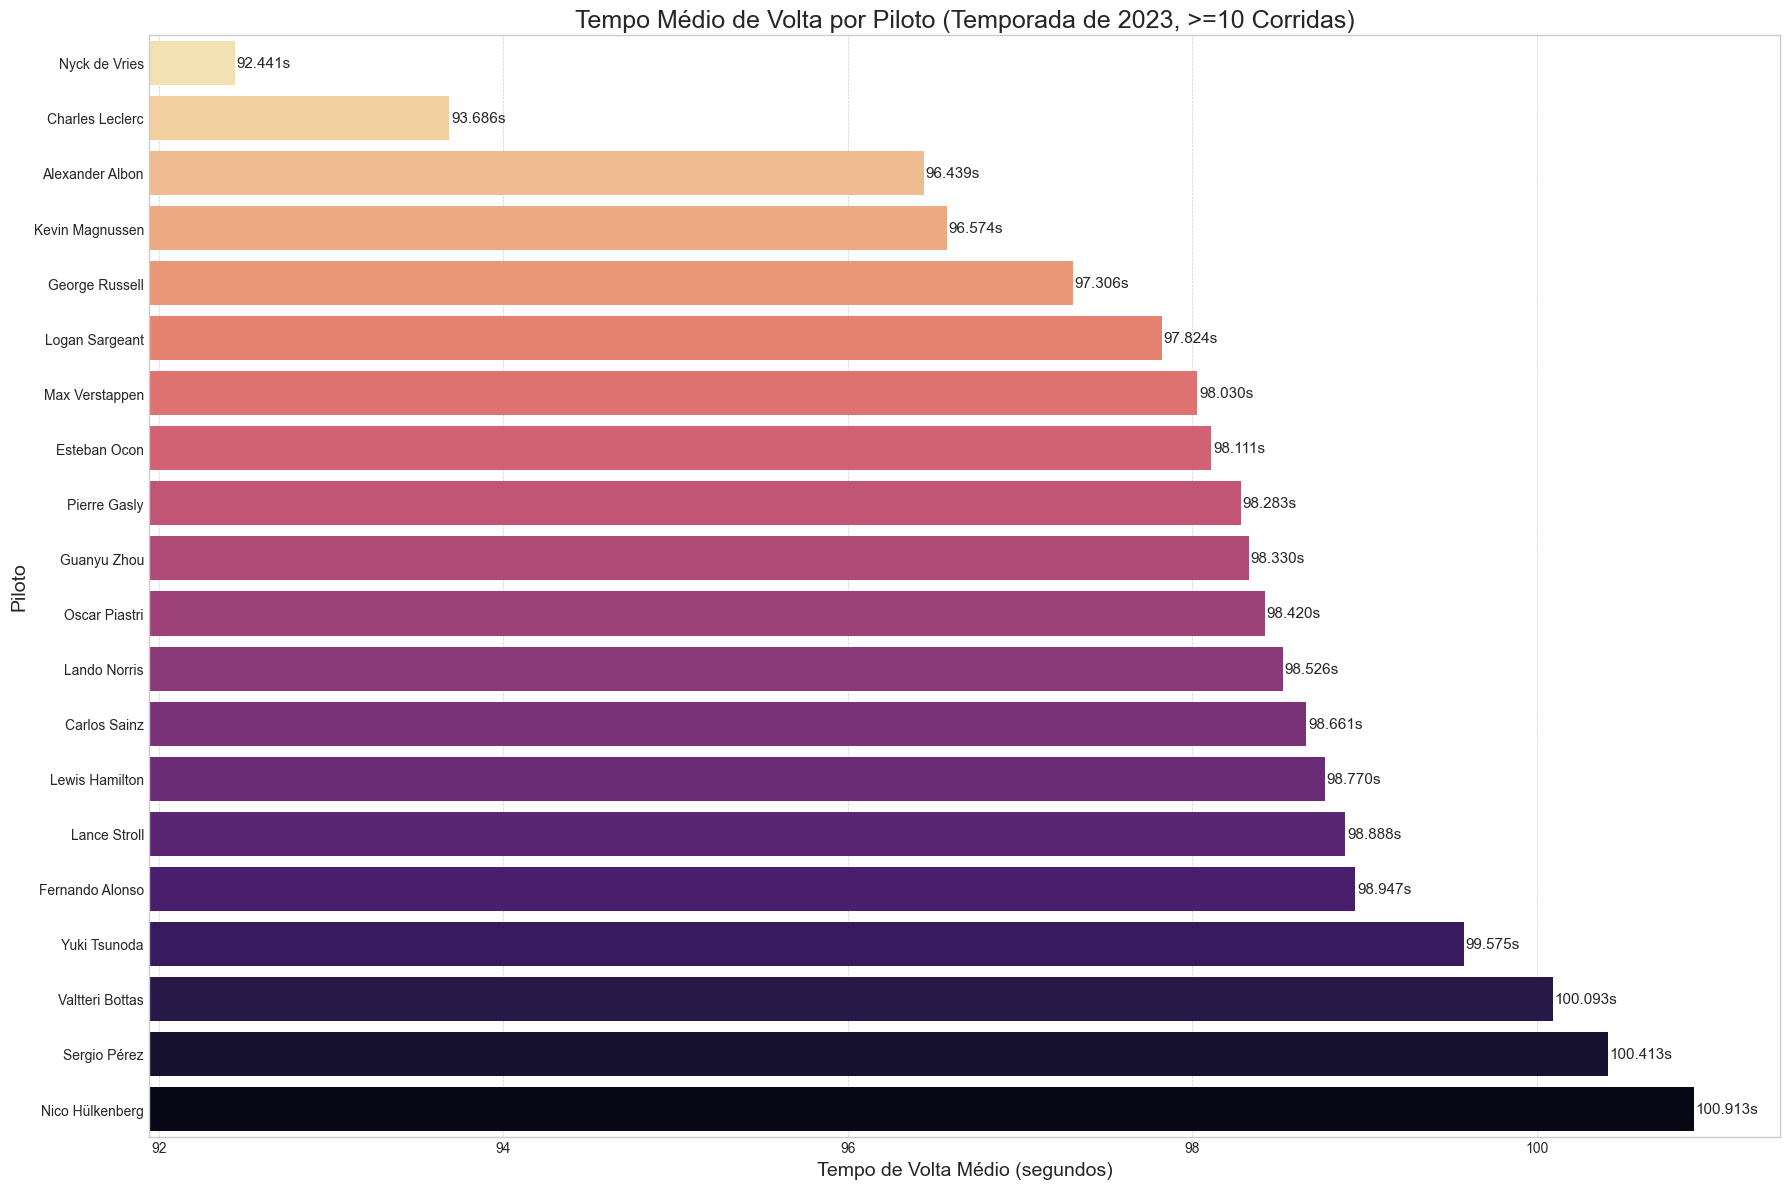

Na temporada de 2023 (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi Nyck de Vries com um tempo de 92.441 segundos.


In [376]:
target_season_year = 2023

# Encontrar os IDs de todas as corridas da temporada
season_races = dataframes['races'].filter(col("year") == target_season_year).select("raceId")

# Filtrar os resultados para a temporada de 2023
season_results = dataframes['results'].join(season_races, "raceId", "inner")

# Contar quantas corridas cada piloto participou
races_per_driver = season_results.groupBy("driverId") \
    .agg(count("raceId").alias("races_participated"))

# Filtrar para obter apenas os pilotos com 10 ou mais corridas
full_season_drivers = races_per_driver.filter(col("races_participated") >= 10).select("driverId")

# --- Lógica PySpark (com dados filtrados por temporada e número de corridas) ---
# 1. Filtrar os tempos de volta para APENAS a temporada selecionada
season_lap_times = dataframes['lap_times'].join(season_races, "raceId", "inner")

# 2. Filtrar novamente para incluir apenas os pilotos que correram 10+ vezes
filtered_lap_times = season_lap_times.join(full_season_drivers, "driverId", "inner")

# 3. Calcular o tempo médio de volta por piloto
avg_lap_time_df = filtered_lap_times.groupBy('driverId').agg(avg('milliseconds').alias('avg_milliseconds'))

# 4. Juntar com os nomes dos pilotos
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
avg_lap_time_with_driver = avg_lap_time_df.join(drivers_with_label, 'driverId') \
    .withColumn('avg_seconds', col('avg_milliseconds') / 1000) \
    .orderBy('avg_seconds')

# 5. Converter para Pandas para plotagem
plot_data_season_filtered = avg_lap_time_with_driver.select('driver_name', 'avg_seconds').toPandas()


# --- Lógica de Plotagem ---
plt.figure(figsize=(18, 12))
ax = sns.barplot(
    x='avg_seconds',
    y='driver_name',
    data=plot_data_season_filtered,
    orient='h',
    palette='magma_r',
    hue='driver_name',
    legend=False
)

# Adicionar o valor exato no final de cada barra
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.01,
        p.get_y() + p.get_height() / 2.,
        f'{width:.3f}s',
        va='center',
        fontsize=11
    )

# Títulos e rótulos
plt.title(f'Tempo Médio de Volta por Piloto (Temporada de {target_season_year}, >=10 Corridas)', fontsize=18)
plt.xlabel('Tempo de Volta Médio (segundos)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

# Ajustar os limites do eixo X dinamicamente
min_time = plot_data_season_filtered['avg_seconds'].min()
max_time = plot_data_season_filtered['avg_seconds'].max()
plt.xlim(left=min_time - 0.5, right=max_time + 0.5)

plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()


# --- Insight ---
fastest_driver_season = plot_data_season_filtered.iloc[0]
print(f"Na temporada de {target_season_year} (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi {fastest_driver_season['driver_name']} com um tempo de {fastest_driver_season['avg_seconds']:.3f} segundos.")

### Voltas recordes por corrida


- **Objetivo do gráfico:** Descobrir quais corridas registraram as voltas mais rápidas da história.
- **Dados utilizados:** `lap_times` para calcular o menor tempo por corrida e `races` para compor o rótulo nome + ano.
- **Ações principais:** Agrupa as voltas por `raceId` pegando o tempo mínimo; junta com os metadados da corrida; converte tempos para segundos; ordena da volta mais rápida para a mais lenta; cria o gráfico de barras horizontal com o Top 20.
- **Saída:** Figura `Volta Mais Rápida por Corrida (Top 20)` e mensagem no console apontando a prova com volta mais veloz.
- **Insight esperado:** Evidenciar eventos com condições excepcionais de desempenho, úteis para análises comparativas por temporada ou circuito.
- **Complemento útil:** Permite correlacionar corridas rápidas com variáveis externas (clima, pneus, regulamento) em estudos adicionais.


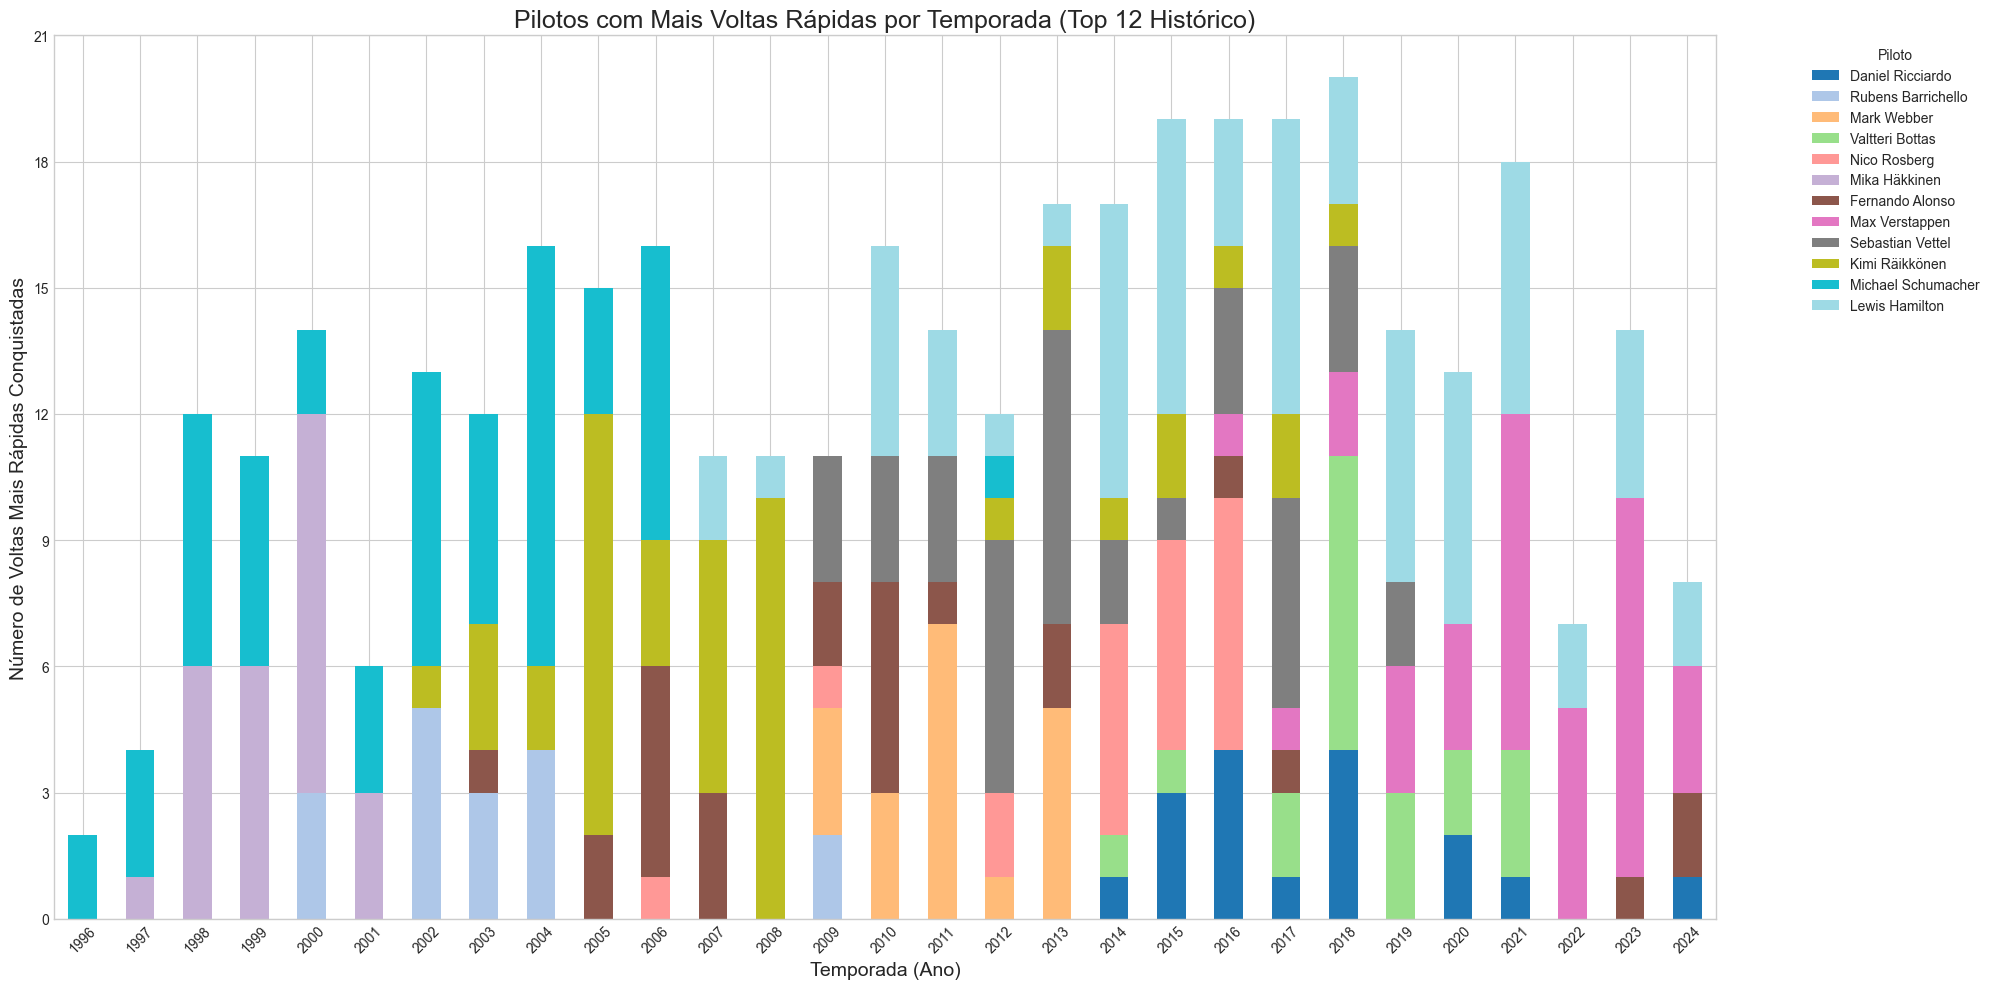

O piloto com mais voltas rápidas na história (presente nos dados) é Lewis Hamilton, com um total de 66 voltas rápidas.


In [377]:
fastest_lap_time_per_race = dataframes['lap_times'].groupBy("raceId").agg(min("milliseconds").alias("fastest_lap_ms"))
fastest_lap_driver_per_race = dataframes['lap_times'].join(fastest_lap_time_per_race, "raceId").filter(col("milliseconds") == col("fastest_lap_ms")).select("raceId", "driverId")
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))
fastest_laps_summary = fastest_lap_driver_per_race.join(dataframes['races'], "raceId").join(drivers_with_label, "driverId").select("year", "driver_name")
fastest_lap_counts = fastest_laps_summary.groupBy("year", "driver_name").agg(count("*").alias("fastest_lap_count")).orderBy("year", "fastest_lap_count")

# Etapa 5: Converter para Pandas e definir a ordem de plotagem
plot_data_stacked = fastest_lap_counts.toPandas()

# --- ALTERAÇÃO APLICADA AQUI ---
# Calcular o total de voltas rápidas de cada piloto para definir a ordem
driver_totals = plot_data_stacked.groupby('driver_name')['fastest_lap_count'].sum()
# Pegar os 12 principais
top_12_names = driver_totals.nlargest(12).index
# Filtrar os totais para ter apenas os 12 principais e ordená-los do menor para o maior
sorted_top_12_totals = driver_totals[top_12_names].sort_values(ascending=True)
# Esta lista agora define a ordem de empilhamento: os menos frequentes em baixo
plot_order = sorted_top_12_totals.index.tolist()

# Filtrar os dados de plotagem para ter apenas esses 12 pilotos
plot_data_filtered = plot_data_stacked[plot_data_stacked['driver_name'].isin(plot_order)]
# --------------------------------

# Etapa 6: Pivotar os dados e REORDENAR as colunas antes de plotar
pivot_df = plot_data_filtered.pivot(index='year', columns='driver_name', values='fastest_lap_count').fillna(0)
pivot_df = pivot_df[plot_order] # Reordenar colunas para controlar a ordem de empilhamento

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    colormap='tab20'
)

# Forçar o eixo Y a usar apenas números inteiros
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Títulos e rótulos
plt.title('Pilotos com Mais Voltas Rápidas por Temporada (Top 12 Histórico)', fontsize=18)
plt.xlabel('Temporada (Ano)', fontsize=14)
plt.ylabel('Número de Voltas Mais Rápidas Conquistadas', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# --- Insight ---
overall_leader = driver_totals.nlargest(1).index[0]
overall_count = driver_totals.nlargest(1).values[0]

print(f"O piloto com mais voltas rápidas na história (presente nos dados) é {overall_leader}, com um total de {overall_count} voltas rápidas.")

### Consistência vs velocidade de pilotos


- **Objetivo do gráfico:** Relacionar velocidade média das voltas com consistência (baixa variabilidade) dos pilotos mais atuantes.
- **Dados utilizados:** `lap_times` para média e desvio padrão por piloto/corrida e `drivers` para rotular os participantes.
- **Ações principais:** Agrupa por corrida e piloto, calculando média e desvio padrão; descarta casos sem variância; seleciona os 15 pilotos mais presentes; converte valores para segundos; gera gráfico de dispersão e calcula o piloto de menor desvio médio.
- **Saída:** Gráfico `Consistência vs. Velocidade Média por Piloto` e mensagem destacando o piloto mais consistente.
- **Insight esperado:** Distinguir pilotos velozes porém instáveis daqueles que combinam rapidez com regularidade.
- **Possíveis extensões:** Incluir tamanho do marcador proporcional ao número de corridas para contextualizar experiência.


C:\Users\julii\AppData\Local\Temp\ipykernel_7464\3008178992.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r')


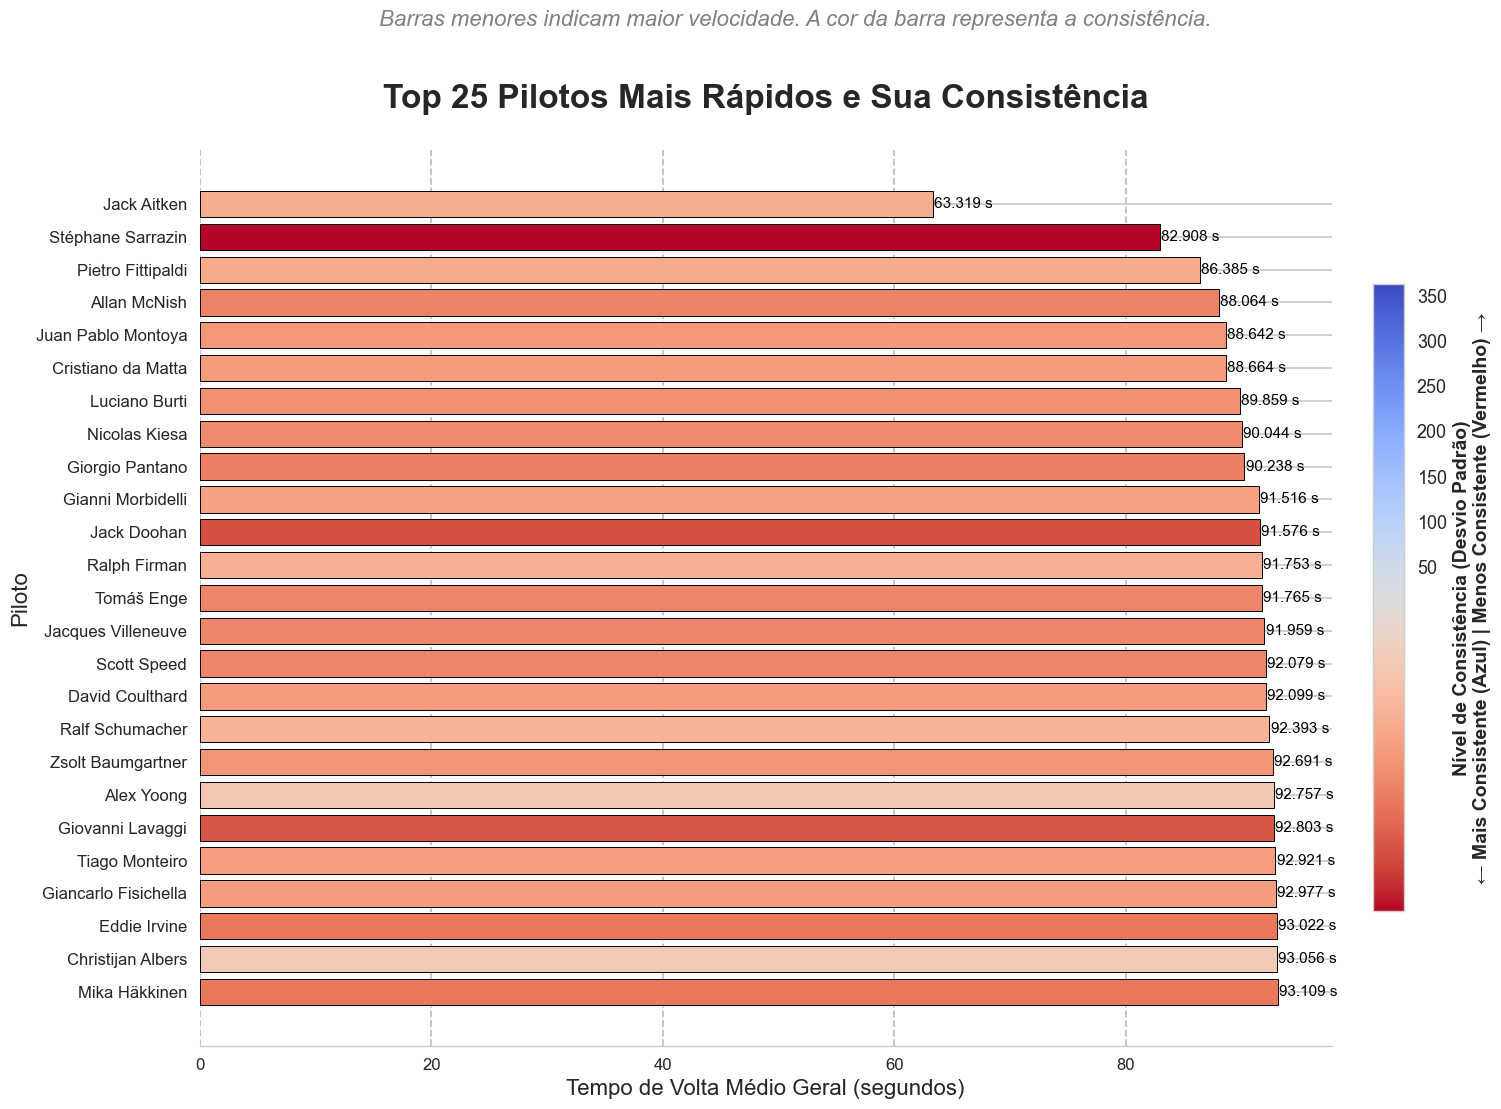

In [378]:
driver_consistency_per_race_df = dataframes['lap_times'].groupBy('raceId', 'driverId').agg(
    stddev('milliseconds').alias('stddev_ms'), avg('milliseconds').alias('avg_ms')
).filter(col('stddev_ms').isNotNull())
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
full_consistency_df = driver_consistency_per_race_df.join(drivers_with_label, 'driverId')
driver_overall_stats = full_consistency_df.groupBy('driver_name').agg(
    avg('avg_ms').alias('overall_avg_ms'),
    avg('stddev_ms').alias('overall_stddev_ms'),
    count('raceId').alias('race_count')
)
plot_data = driver_overall_stats.withColumn(
    'overall_avg_s', col('overall_avg_ms') / 1000
).withColumn(
    'overall_stddev_s', col('overall_stddev_ms') / 1000
).select('driver_name', 'overall_avg_s', 'overall_stddev_s').toPandas()


# --- Etapa 4 (CORRIGIDA): Preparação para o Gráfico de Barras Ranqueado ---

# Filtra e ordena os dados: Top 25 pilotos mais rápidos
top_n = 25
chart_data = plot_data.sort_values('overall_avg_s', ascending=True).head(top_n)

# ##################################################################
# ## CORREÇÃO APLICADA AQUI ##
# Define vmin, vcenter, e vmax usando o CONJUNTO DE DADOS COMPLETO (`plot_data`)
# Isso garante que a ordem crescente seja sempre respeitada.
vmin_global = plot_data['overall_stddev_s'].min()
vcenter_global = plot_data['overall_stddev_s'].median()
vmax_global = plot_data['overall_stddev_s'].max()

# Cria o normalizador para o mapa de cores usando os valores globais
norm = mcolors.TwoSlopeNorm(vmin=vmin_global, 
                            vcenter=vcenter_global, 
                            vmax=vmax_global)
# ##################################################################

# Escolhe um mapa de cores divergente e invertido (menor = melhor = azul)
cmap = plt.cm.get_cmap('coolwarm_r')


# --- Etapa 5 (Sem alterações): Visualização Reestruturada ---

plt.style.use('seaborn-v0_8-talk')
fig, ax = plt.subplots(figsize=(16, 12))

# Cria o gráfico de barras horizontais
bars = ax.barh(
    chart_data['driver_name'],
    chart_data['overall_avg_s'],
    color=cmap(norm(chart_data['overall_stddev_s'].values)), # Aplica as cores normalizadas
    edgecolor='black',
    linewidth=0.7
)

# Inverte o eixo Y para que o mais rápido (menor tempo) fique no topo
ax.invert_yaxis()

# Adiciona os valores de tempo de volta no final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f'{width:.3f} s',
            ha='left', va='center', fontsize=11, color='black')

# Configurações de títulos e rótulos
ax.set_title(f'Top {top_n} Pilotos Mais Rápidos e Sua Consistência', fontsize=24, weight='bold', pad=30)
ax.set_xlabel('Tempo de Volta Médio Geral (segundos)', fontsize=16)
ax.set_ylabel('Piloto', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Remove as bordas desnecessárias
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Adiciona uma linha de grid vertical para referência
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Cria e posiciona a legenda de cor (colorbar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('Nível de Consistência (Desvio Padrão)\n← Mais Consistente (Azul) | Menos Consistente (Vermelho) →', 
               fontsize=14, weight='bold')

# Adiciona um subtítulo explicativo
fig.suptitle('Barras menores indicam maior velocidade. A cor da barra representa a consistência.',
             y=0.92, fontsize=16, style='italic', color='grey')


plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Evolução média dentro da corrida


- **Objetivo do gráfico:** Entender como o tempo médio de volta evolui ao longo de uma corrida típica.
- **Dados utilizados:** `lap_times` agregados por número de volta em toda a história disponível.
- **Ações principais:** Calcula a média por volta, converte para segundos, filtra até a volta 70, aplica média móvel de 4 voltas e plota duas séries (original e suavizada).
- **Saída:** Gráfico `Evolução do Tempo Médio de Volta Durante as Corridas` com série original e média móvel.
- **Insight esperado:** Detectar fases onde os carros tendem a acelerar ou desacelerar, influenciadas por combustível, pneus ou safety cars.
- **Sugestão analítica:** Comparar segmentos de voltas (ex.: 1-10, 11-20) para corroborar hipóteses sobre estratégias de pit stop.


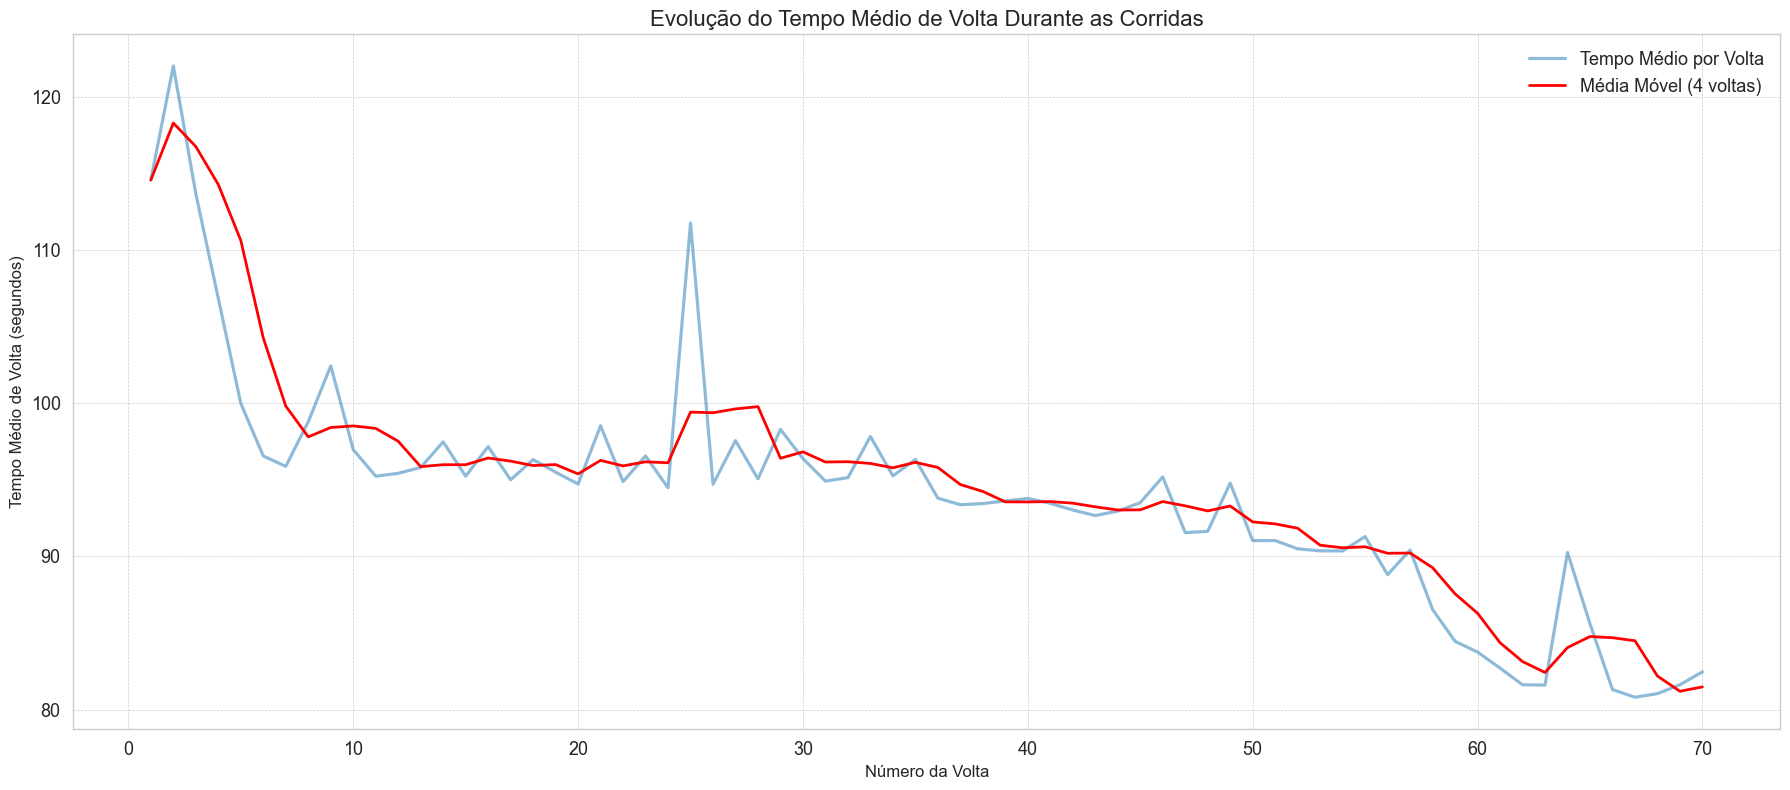

In [379]:
from pyspark.sql.functions import avg, col
lap_evolution_df = dataframes['lap_times'].groupBy('lap').agg(avg('milliseconds').alias('avg_ms')).withColumn('avg_s', col('avg_ms') / 1000).orderBy('lap')
plot_data_6 = lap_evolution_df.filter(col('lap') <= 70).toPandas()
plot_data_6['rolling_avg_s'] = plot_data_6['avg_s'].rolling(window=4, min_periods=1).mean()
plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data_6, x='lap', y='avg_s', label='Tempo Médio por Volta', alpha=0.5)
sns.lineplot(data=plot_data_6, x='lap', y='rolling_avg_s', label='Média Móvel (4 voltas)', color='red', linewidth=2)
plt.title('Evolução do Tempo Médio de Volta Durante as Corridas', fontsize=16)
plt.xlabel('Número da Volta', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Melhor volta individual de cada piloto


- **Objetivo do gráfico:** Listar os pilotos que registraram as voltas mais rápidas absolutas na base.
- **Dados utilizados:** `lap_times` para o tempo mínimo por piloto e `drivers` para montar o nome completo.
- **Ações principais:** Calcula o menor tempo por `driverId`, junta com nomes, converte para segundos, ordena, transforma em Pandas e plota o Top 25 em barras horizontais.
- **Saída:** Gráfico `Melhor Volta Pessoal de Cada Piloto (Top 25)` e impressão do recordista geral.
- **Insight esperado:** Fornecer referência de pico de performance individual, útil para comparar talentos ou eras.
- **Nota contextual:** Voltas rápidas podem refletir compostos de pneus, regimes de combustível e regulamentações específicas de cada ano.


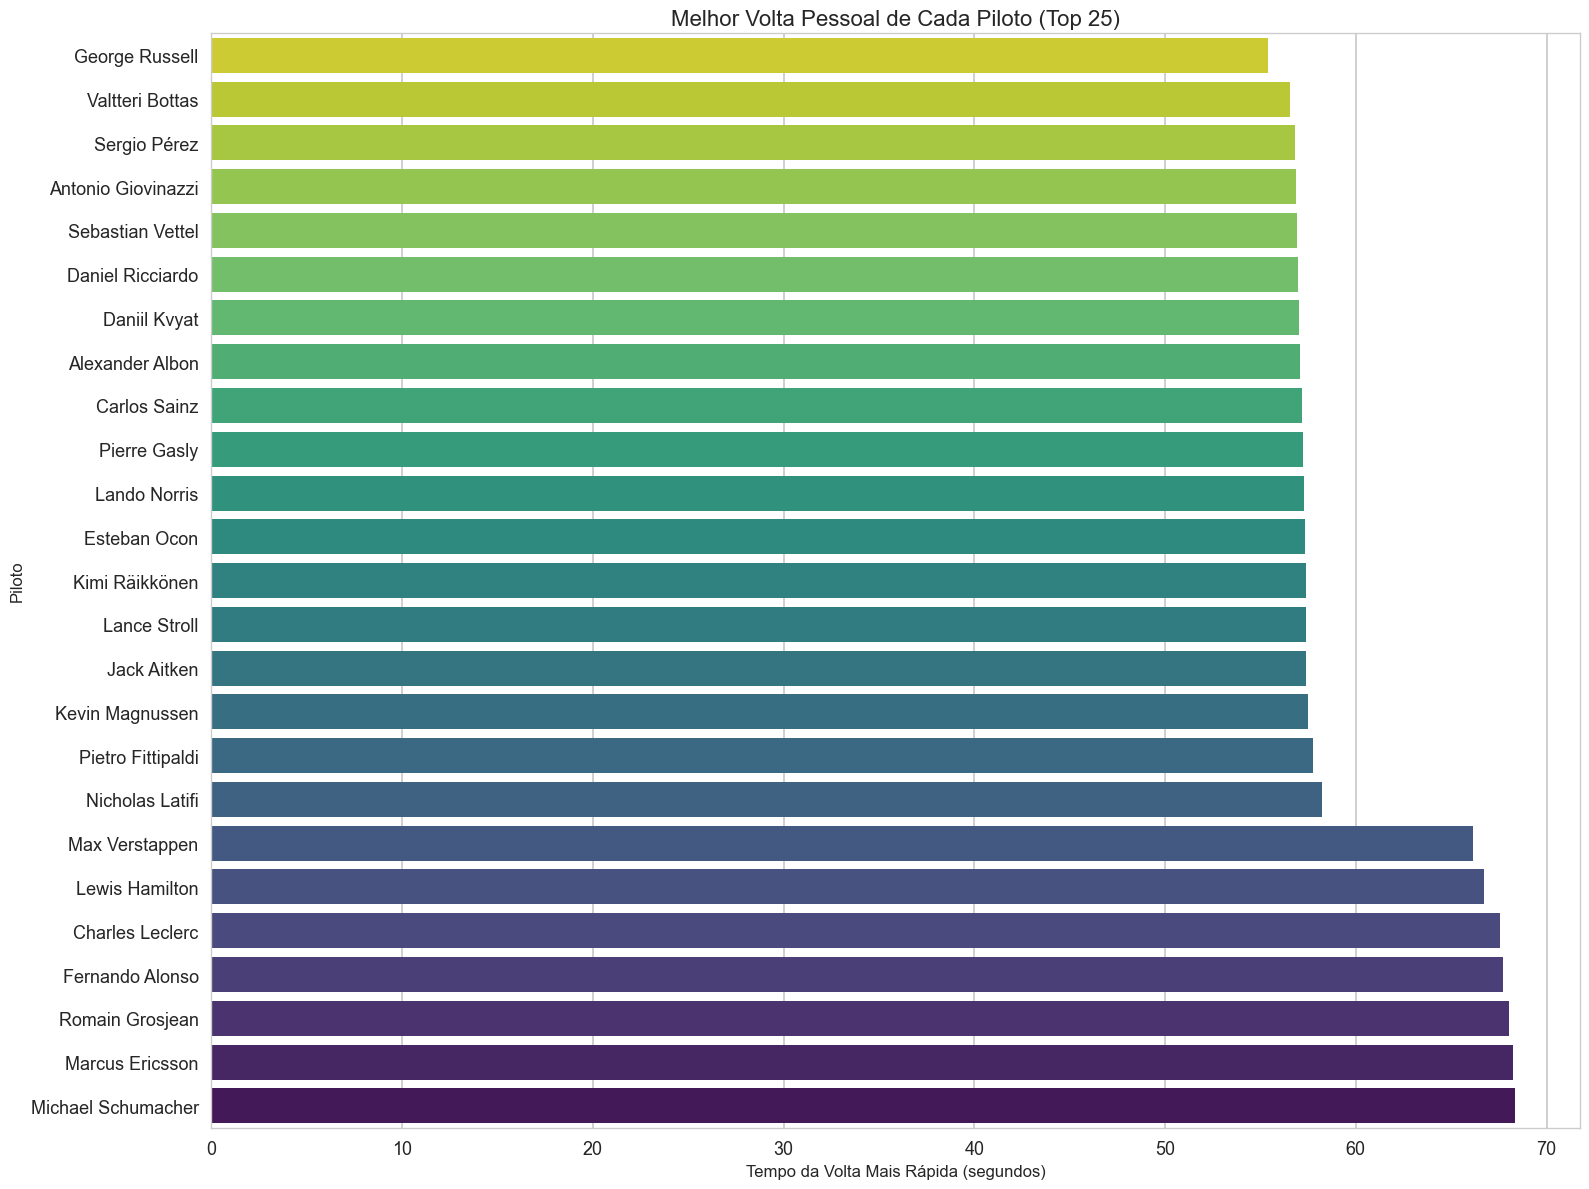

O piloto com a volta mais rápida de todos os tempos na base de dados é George Russell com o tempo de 55.404 segundos.


In [380]:
from pyspark.sql.functions import min, col, concat_ws
fastest_lap_per_driver = dataframes['lap_times'].groupBy('driverId').agg(min('milliseconds').alias('fastest_lap_ms'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_fastest_lap_details = fastest_lap_per_driver.join(drivers_with_label, 'driverId').withColumn('fastest_lap_s', col('fastest_lap_ms') / 1000).orderBy('fastest_lap_s')
plot_data_7 = driver_fastest_lap_details.select('driver_name', 'fastest_lap_s').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_7.head(25), x='fastest_lap_s', y='driver_name', orient='h', palette='viridis_r', hue='driver_name', legend=False)
plt.title('Melhor Volta Pessoal de Cada Piloto (Top 25)', fontsize=16)
plt.xlabel('Tempo da Volta Mais Rápida (segundos)', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
fastest_driver_overall = plot_data_7.iloc[0]
print(f"O piloto com a volta mais rápida de todos os tempos na base de dados é {fastest_driver_overall['driver_name']} com o tempo de {fastest_driver_overall['fastest_lap_s']:.3f} segundos.")


### Desempenho médio por construtor


- **Objetivo do gráfico:** Avaliar quais construtores registram menor tempo médio de volta.
- **Dados utilizados:** `lap_times` combinados com `results` (para mapear construtor) e `constructors` (nome da equipe).
- **Ações principais:** Cria o mapa corrida/piloto/construtor, associa aos tempos de volta, calcula a média por equipe, converte para segundos, ordena e plota o Top 25.
- **Saída:** Gráfico `Tempo Médio de Volta por Construtor (Top 25)` e mensagem apontando a equipe mais veloz em média.
- **Insight esperado:** Compreender a dominância técnica das equipes em ritmo de corrida.
- **Ponto de atenção:** Diferenças na quantidade de temporadas disputadas podem distorcer a média; considerar normalização futura.


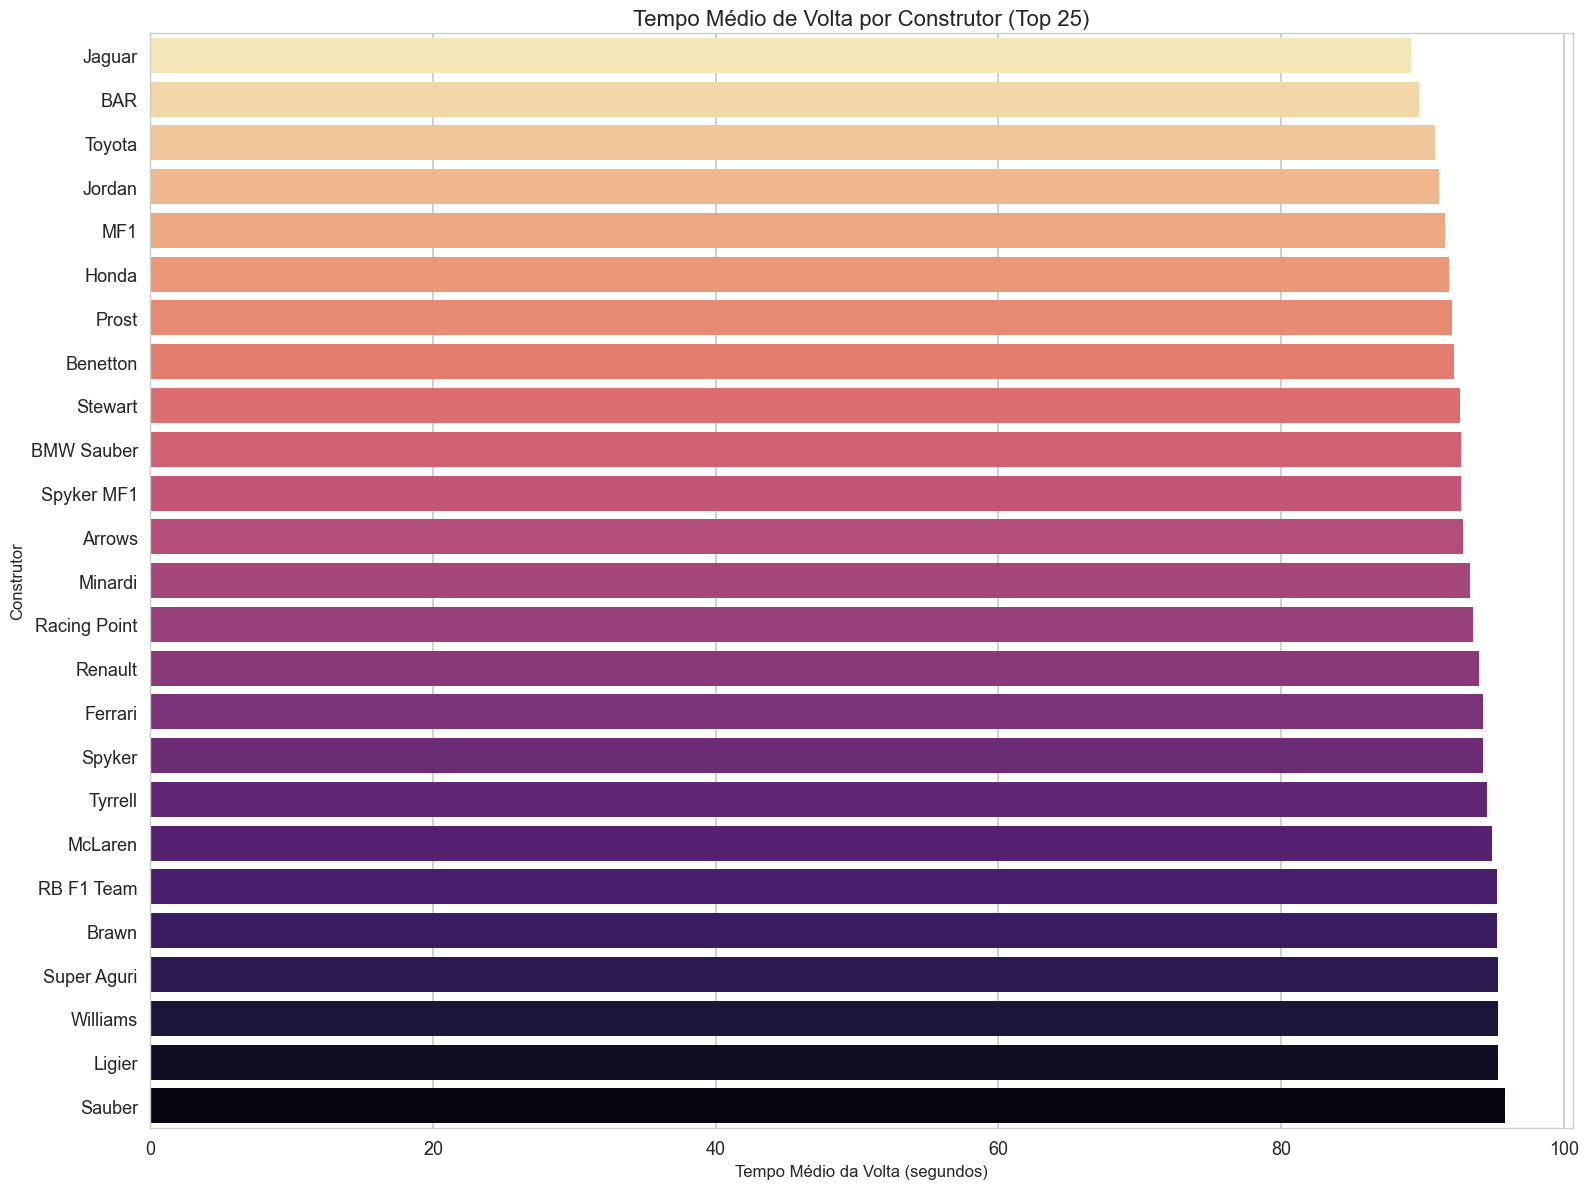

A equipe com os carros mais rápidos em média é: Jaguar com um tempo médio de volta de 89.169 segundos.


In [381]:
from pyspark.sql.functions import avg, col
race_driver_constructor_map = dataframes['results'].select('raceId', 'driverId', 'constructorId').distinct()
laps_with_constructors = dataframes['lap_times'].join(race_driver_constructor_map, on=['raceId', 'driverId'], how='inner')
avg_time_per_constructor = laps_with_constructors.groupBy('constructorId').agg(avg('milliseconds').alias('avg_ms'))
constructor_lap_details = avg_time_per_constructor.join(dataframes['constructors'], 'constructorId').withColumn('avg_s', col('avg_ms') / 1000).orderBy('avg_s')
plot_data_8 = constructor_lap_details.select('name', 'avg_s').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_8.head(25), x='avg_s', y='name', orient='h', palette='magma_r', hue='name', legend=False)
plt.title('Tempo Médio de Volta por Construtor (Top 25)', fontsize=16)
plt.xlabel('Tempo Médio da Volta (segundos)', fontsize=12)
plt.ylabel('Construtor', fontsize=12)
plt.tight_layout()
plt.show()
fastest_constructor = plot_data_8.iloc[0]
print(f"A equipe com os carros mais rápidos em média é: {fastest_constructor['name']} com um tempo médio de volta de {fastest_constructor['avg_s']:.3f} segundos.")


### Velocidade média por país


- **Objetivo do gráfico:** Rankear países pelos tempos médios das voltas realizadas em seus circuitos.
- **Dados utilizados:** `lap_times` (médias por corrida) aliados a `races` e `circuits` para identificar o país.
- **Ações principais:** Liga cada corrida ao país, agrega os tempos médios por país, converte para segundos, ordena e cria DataFrame Pandas para visualização.
- **Saída:** Gráfico `Velocidade Média por País do Circuito` abrangendo todos os países presentes.
- **Insight esperado:** Indicar localizações onde as pistas tendem a ser mais rápidas ou lentas, auxiliando comparações geográficas.
- **Análise complementar:** Cruzar o ranking com dados de clima, altitude ou layout para explicar diferenças observadas.


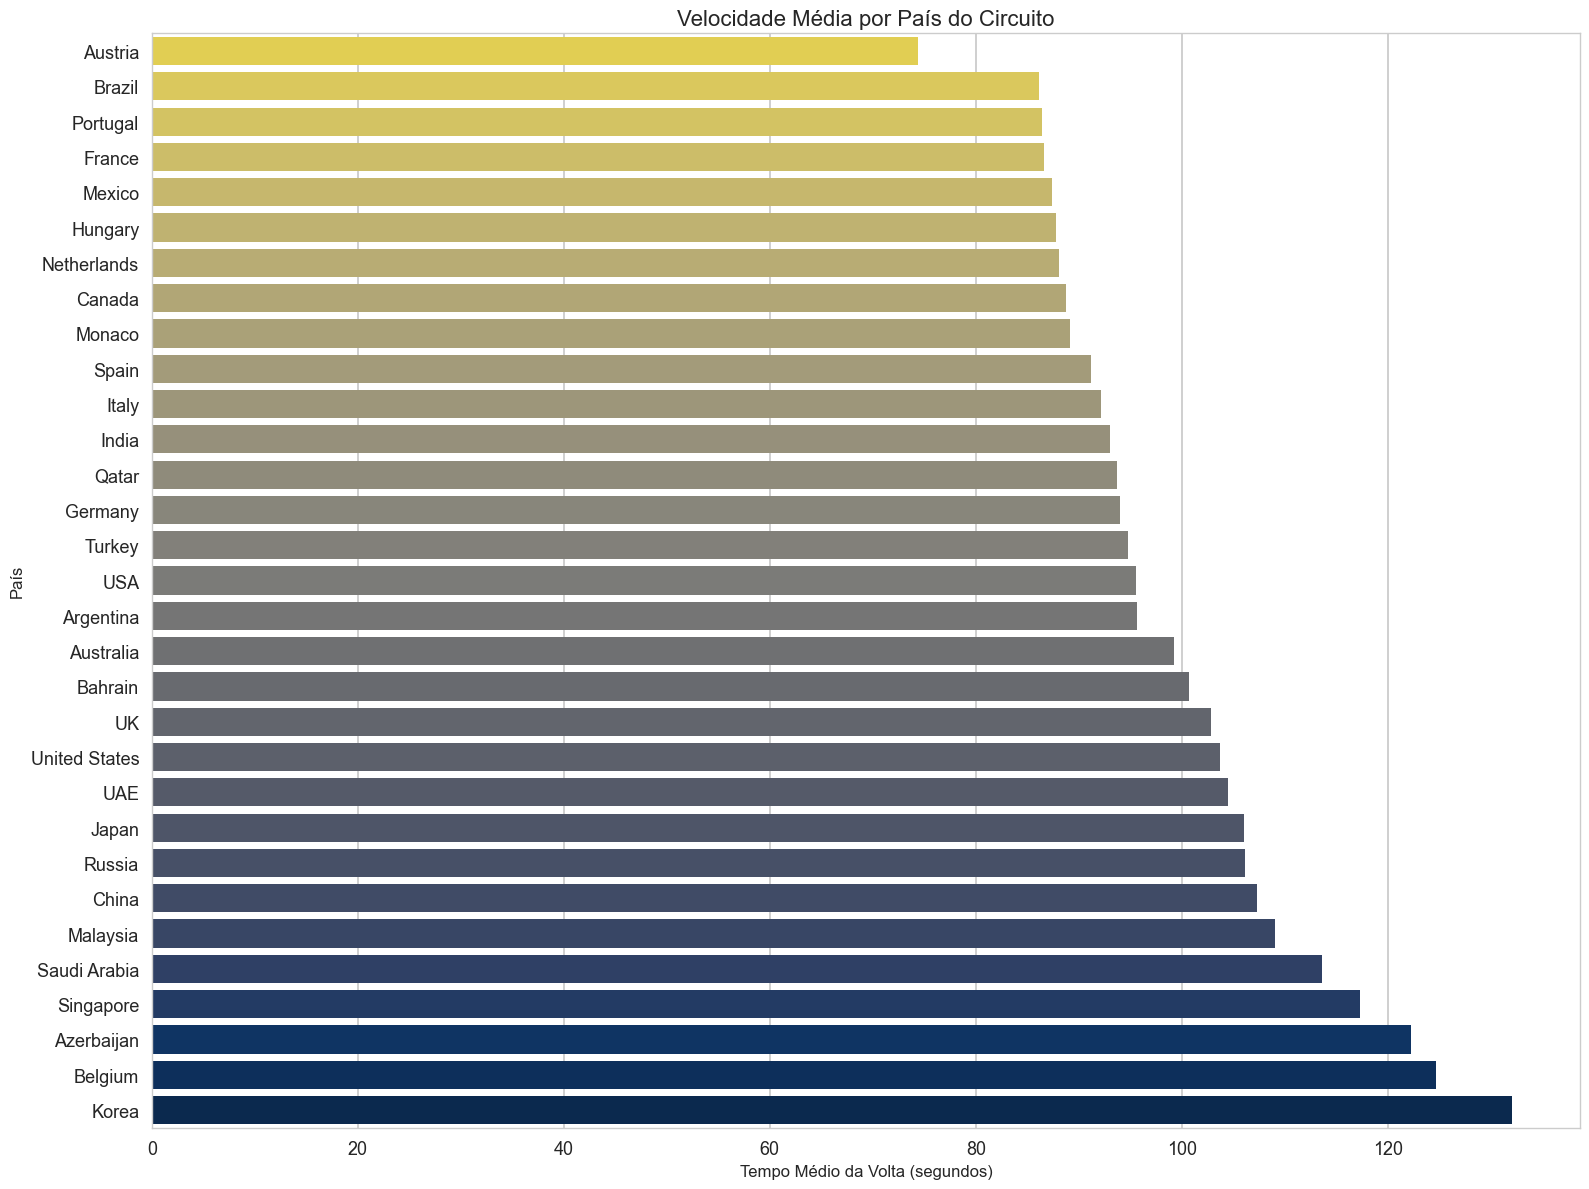

As pistas mais velozes, em média, estão na: Austria com um tempo médio de volta de 74.421 segundos.


In [382]:
from pyspark.sql.functions import avg, col
avg_time_per_race = dataframes['lap_times'].groupBy('raceId').agg(avg('milliseconds').alias('avg_lap_ms_race'))
race_circuit_join = avg_time_per_race.join(dataframes['races'], 'raceId')
race_country_join = race_circuit_join.join(dataframes['circuits'], 'circuitId')
avg_time_per_country = race_country_join.groupBy('country').agg(avg('avg_lap_ms_race').alias('avg_country_ms')).withColumn('avg_country_s', col('avg_country_ms') / 1000).orderBy('avg_country_s')
plot_data_9 = avg_time_per_country.select('country', 'avg_country_s').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_9, x='avg_country_s', y='country', orient='h', palette='cividis_r', hue='country', legend=False)
plt.title('Velocidade Média por País do Circuito', fontsize=16)
plt.xlabel('Tempo Médio da Volta (segundos)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.tight_layout()
plt.show()
fastest_country = plot_data_9.iloc[0]
print(f"As pistas mais velozes, em média, estão na: {fastest_country['country']} com um tempo médio de volta de {fastest_country['avg_country_s']:.3f} segundos.")


### Ganho ou perda entre voltas consecutivas


- **Objetivo do gráfico:** Quantificar o ganho ou perda média ao comparar cada volta com a imediatamente anterior.
- **Dados utilizados:** `lap_times` tratados com janelas (`Window`) particionadas por corrida e piloto.
- **Ações principais:** Usa `lag` para recuperar a volta anterior, calcula a diferença, remove valores nulos, agrega por número de volta, limita às 70 primeiras e converte diferenças para segundos.
- **Saída:** Gráfico `Diferença Média Entre Voltas Consecutivas` com coloração distinta para ganhos e perdas.
- **Insight esperado:** Destacar momentos da corrida onde o ritmo coletivo tende a cair ou melhorar (pit stops, safety car, desgaste de pneus).
- **Leitura recomendada:** Observar mudanças de sinal para detectar voltas críticas em estratégia de corrida.


C:\Users\julii\AppData\Local\Temp\ipykernel_7464\2858437228.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data_10, x='lap', y='avg_delta_s', palette=palette)


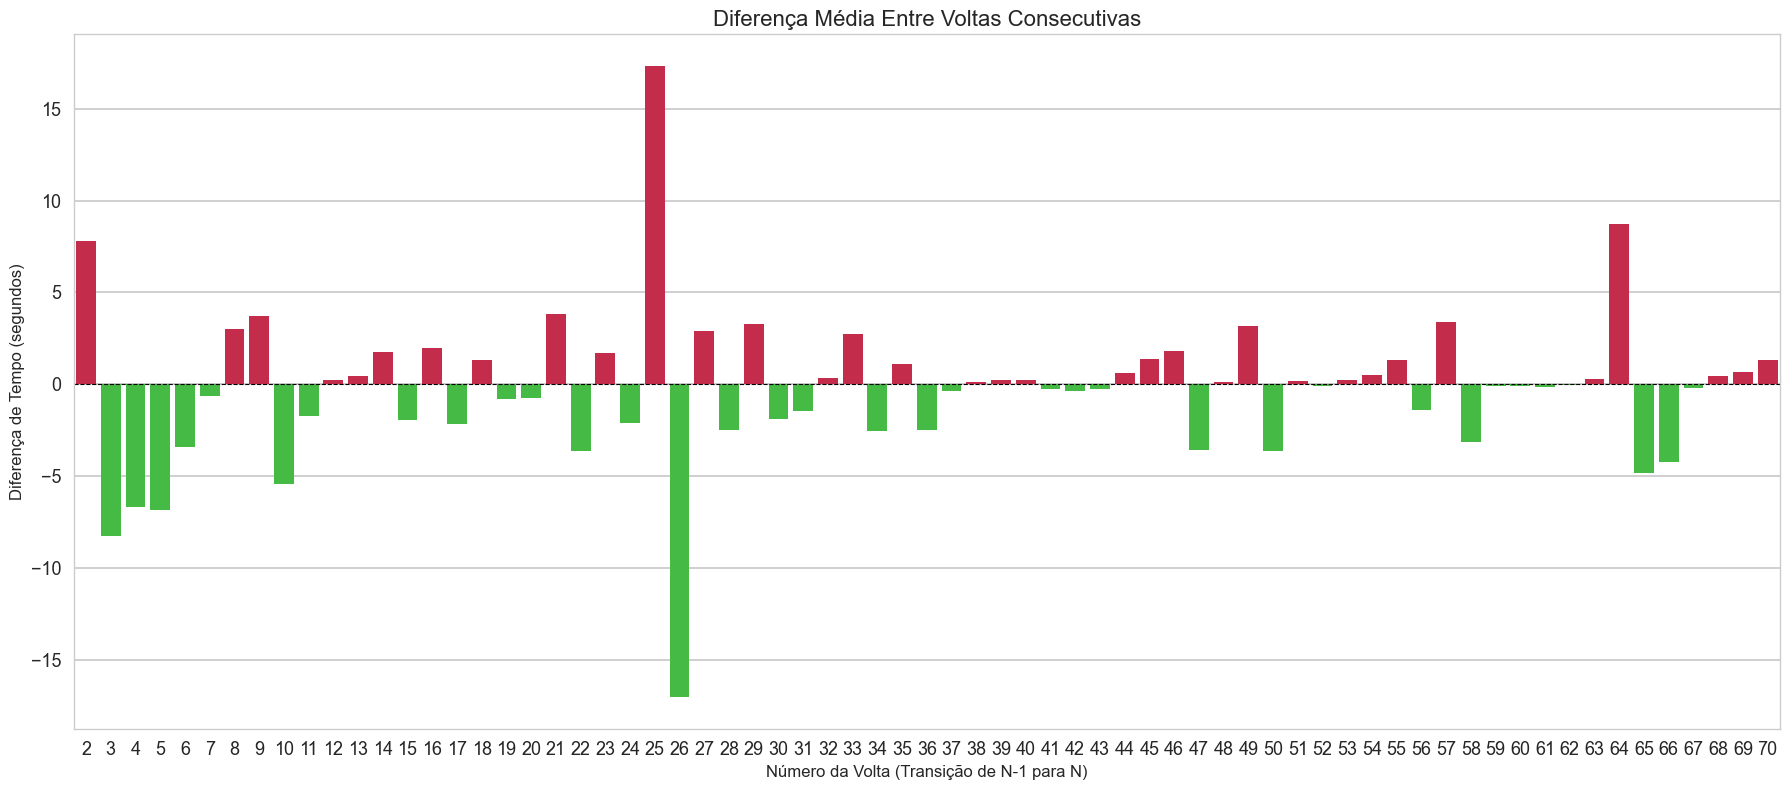

In [383]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, avg
window_spec = Window.partitionBy('raceId', 'driverId').orderBy('lap')
laps_with_previous = dataframes['lap_times'].withColumn('prev_lap_ms', lag('milliseconds', 1).over(window_spec))
lap_delta_df = laps_with_previous.withColumn('delta_ms', col('milliseconds') - col('prev_lap_ms')).filter(col('delta_ms').isNotNull())
avg_delta_per_lap = lap_delta_df.groupBy('lap').agg(avg('delta_ms').alias('avg_delta_ms')).withColumn('avg_delta_s', col('avg_delta_ms') / 1000).orderBy('lap')
plot_data_10 = avg_delta_per_lap.filter(col('lap') <= 70).toPandas()
plt.figure(figsize=(18, 8))
palette = ['crimson' if x > 0 else 'limegreen' for x in plot_data_10['avg_delta_s']]
sns.barplot(data=plot_data_10, x='lap', y='avg_delta_s', palette=palette)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Diferença Média Entre Voltas Consecutivas', fontsize=16)
plt.xlabel('Número da Volta (Transição de N-1 para N)', fontsize=12)
plt.ylabel('Diferença de Tempo (segundos)', fontsize=12)
plt.tight_layout()
plt.show()


### Posição média de pilotos experientes


- **Objetivo do gráfico:** Comparar a posição média de chegada entre pilotos com grande volume de voltas acumuladas.
- **Dados utilizados:** `lap_times` para posições e contagem de voltas, `drivers` para rotular.
- **Ações principais:** Filtra pilotos com mais de 2000 voltas, calcula a posição média, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Posição Média em Corrida por Piloto (com mais de 2000 voltas)` e mensagem com o piloto de melhor média.
- **Insight esperado:** Destacar competidores que se mantêm regularmente nas primeiras posições quando têm amostra representativa.
- **Consideração adicional:** Cruzar com equipes ou períodos históricos para contextualizar a média encontrada.


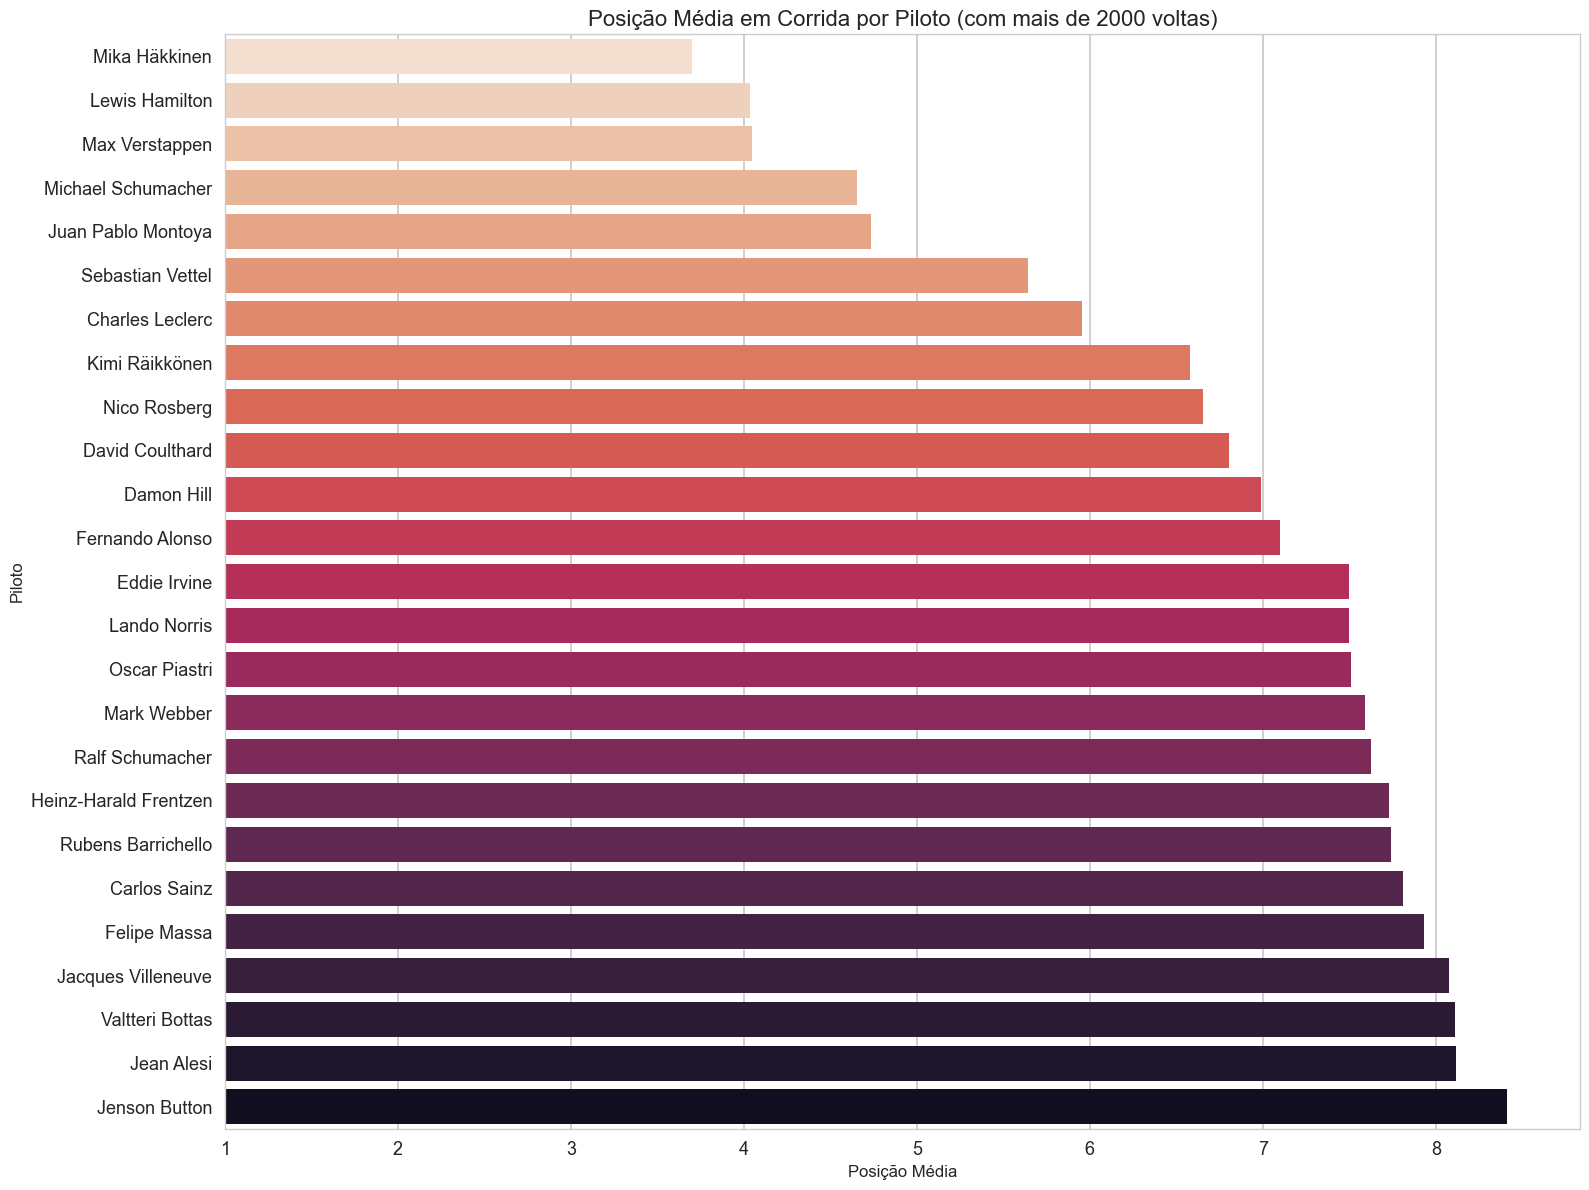

O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: Mika Häkkinen com uma posição média de 3.70.


In [384]:
from pyspark.sql.functions import avg, col, count, concat_ws
experienced_drivers = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps')).filter(col('total_laps') > 2000).select('driverId')
avg_position_per_driver = dataframes['lap_times'].join(experienced_drivers, 'driverId', 'inner').groupBy('driverId').agg(avg('position').alias('avg_position'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_avg_position_details = avg_position_per_driver.join(drivers_with_label, 'driverId').orderBy('avg_position')
plot_data_11 = driver_avg_position_details.select('driver_name', 'avg_position').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_11.head(25), x='avg_position', y='driver_name', orient='h', palette='rocket_r', hue='driver_name', legend=False)
plt.xlim(left=1)
plt.title('Posição Média em Corrida por Piloto (com mais de 2000 voltas)', fontsize=16)
plt.xlabel('Posição Média', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
most_stable_driver = plot_data_11.iloc[0]
print(f"O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: {most_stable_driver['driver_name']} com uma posição média de {most_stable_driver['avg_position']:.2f}.")


### Total de voltas por piloto


- **Objetivo do gráfico:** Medir a quilometragem total de cada piloto em número de voltas completadas.
- **Dados utilizados:** `lap_times` para contagem de voltas e `drivers` para nomes.
- **Ações principais:** Agrupa por piloto, conta o total de voltas, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Total de Voltas Completadas por Piloto (Top 25)` e texto indicando o piloto mais longevo.
- **Insight esperado:** Evidenciar resistência e permanência na categoria, base para analisar carreiras longas.
- **Complemento sugerido:** Relacionar com número de corridas disputadas ou temporadas para obter métricas proporcionais.


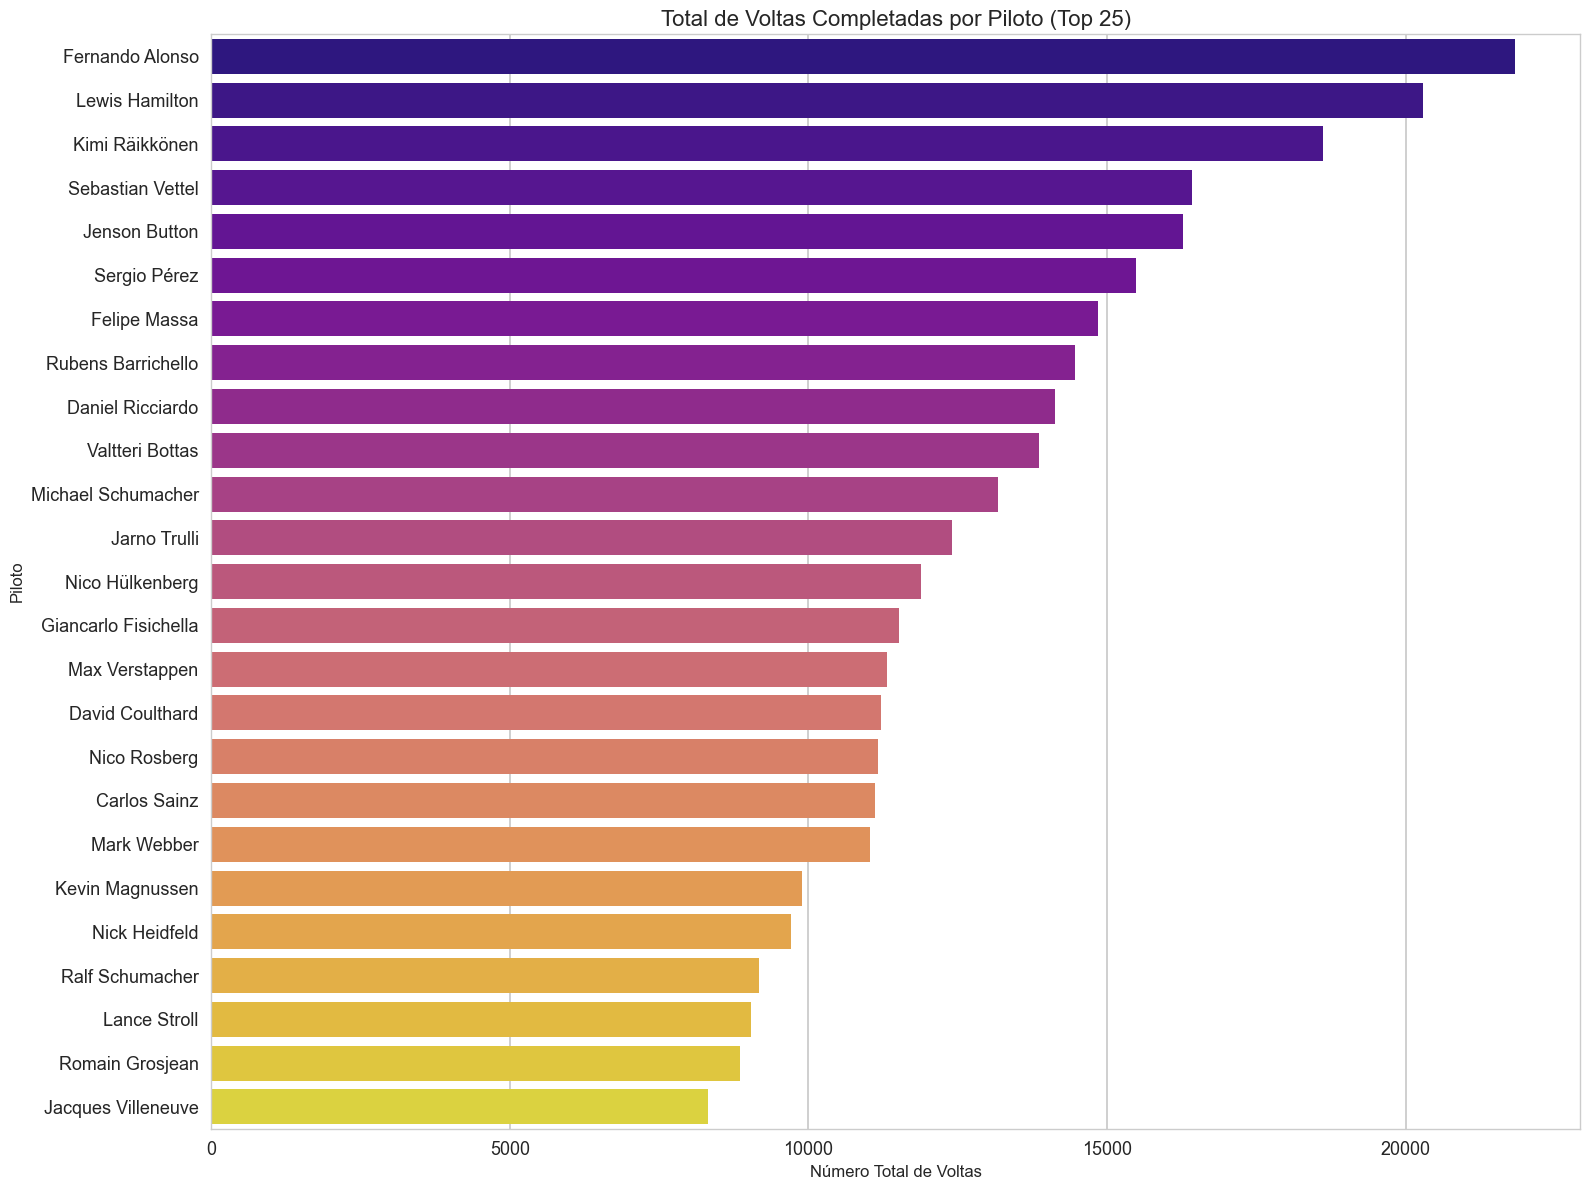

O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21829 voltas.


In [385]:
from pyspark.sql.functions import count, col, concat_ws
total_laps_per_driver = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_laps_details = total_laps_per_driver.join(drivers_with_label, 'driverId').orderBy(col('total_laps').desc())
plot_data_12 = driver_laps_details.select('driver_name', 'total_laps').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_12.head(25), x='total_laps', y='driver_name', orient='h', palette='plasma', hue='driver_name', legend=False)
plt.title('Total de Voltas Completadas por Piloto (Top 25)', fontsize=16)
plt.xlabel('Número Total de Voltas', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
most_laps_driver = plot_data_12.iloc[0]
print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']} voltas.")


### Total de voltas por piloto (variação com salvamento)


- **Objetivo do gráfico:** Disponibilizar a mesma métrica de voltas completadas em um bloco pronto para ajustes de salvamento da figura.
- **Dados utilizados:** `lap_times` e `drivers`, reaproveitando a mesma estrutura da célula anterior.
- **Ações principais:** Reconta voltas por piloto com importações explícitas, transforma em Pandas e plota o Top 25 em barras horizontais.
- **Saída:** Gráfico `Total de Voltas Completadas por Piloto (Top 25)` replicado, facilitando exportações personalizadas.
- **Insight esperado:** Garantir uma versão facilmente adaptável da visualização para apresentações ou relatórios.
- **Observação:** Pode ser ajustado para outros filtros (pilotos ativos, equipes) sem afetar análises anteriores.


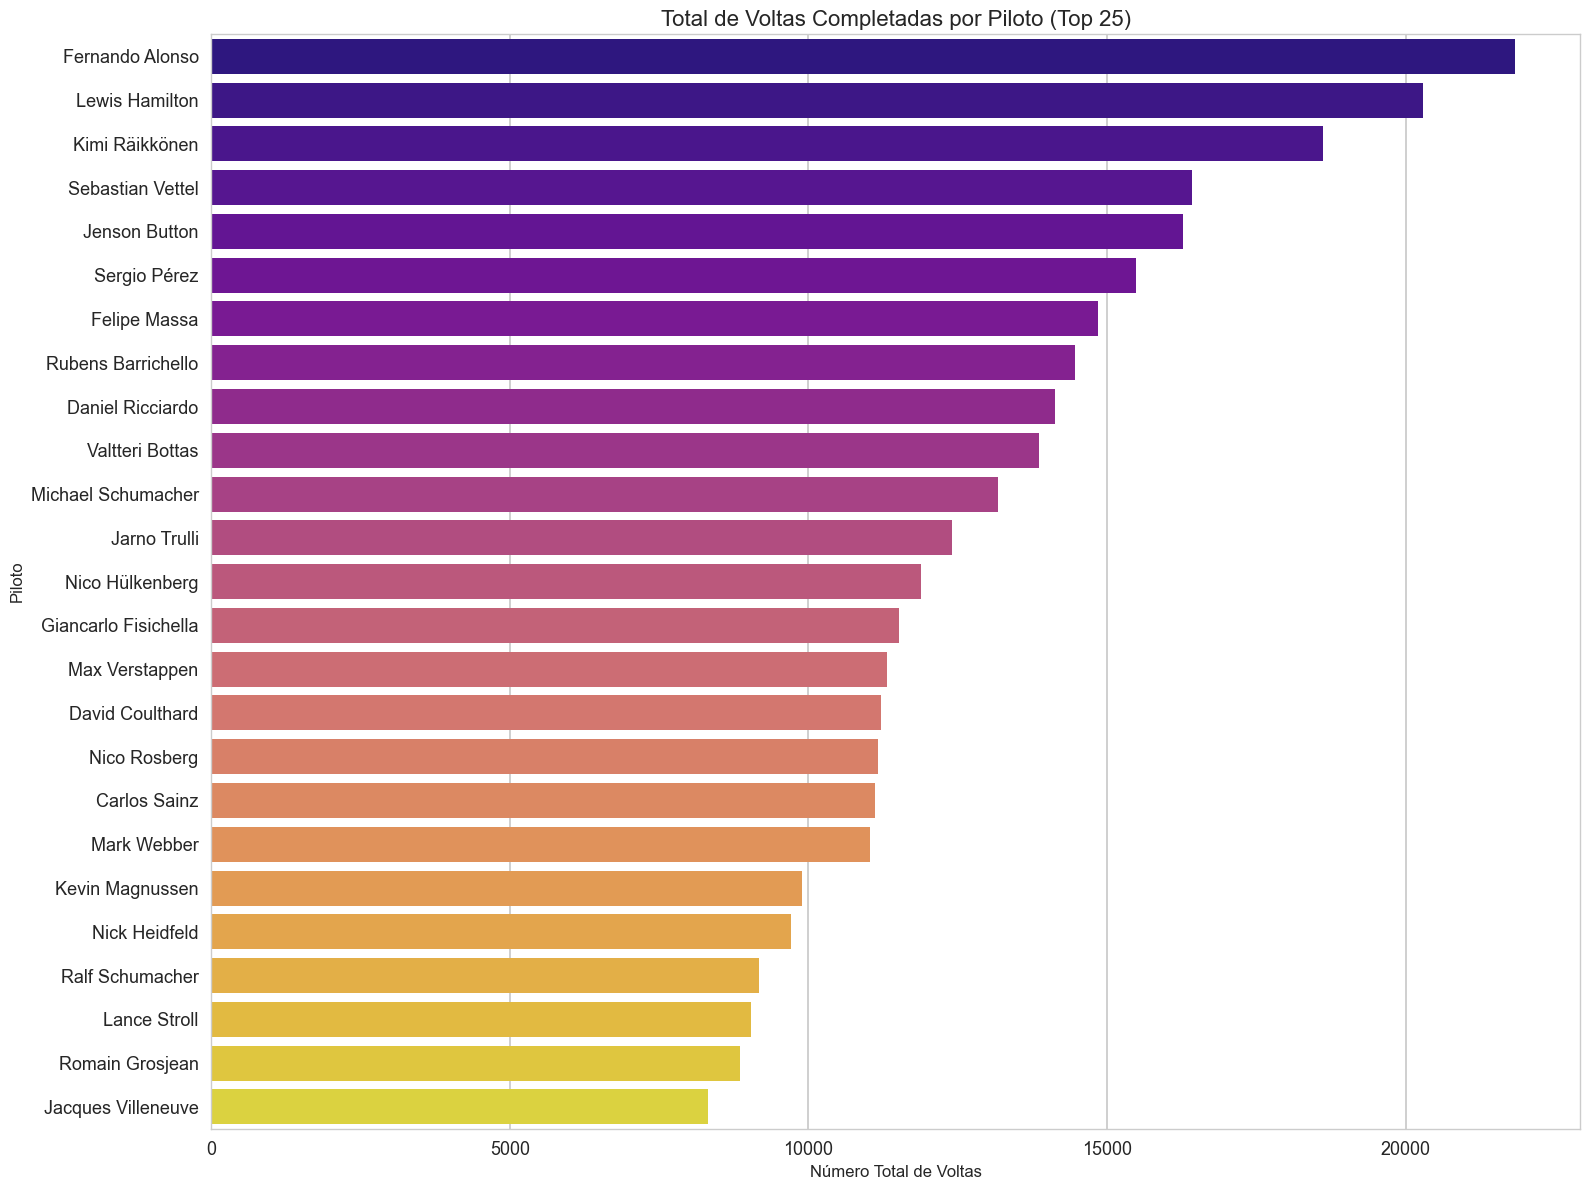

O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21829 voltas.


In [386]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import count, col, concat_ws
total_laps_per_driver = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_laps_details = total_laps_per_driver.join(drivers_with_label, 'driverId').orderBy(col('total_laps').desc())
plot_data_12 = driver_laps_details.select('driver_name', 'total_laps').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_12.head(25), x='total_laps', y='driver_name', orient='h', palette='plasma', hue='driver_name', legend=False)
plt.title('Total de Voltas Completadas por Piloto (Top 25)', fontsize=16)
plt.xlabel('Número Total de Voltas', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
most_laps_driver = plot_data_12.iloc[0]
print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']} voltas.")


### Dispersão de performance por circuito


- **Objetivo do gráfico:** Avaliar o quão disputado ou dominado é cada circuito medindo a dispersão dos tempos médios dos pilotos.
- **Dados utilizados:** `lap_times` combinados com `races` e `circuits` para ligar pilotos a circuitos.
- **Ações principais:** Calcula o tempo médio de cada piloto por circuito, agrega o desvio padrão por pista, converte para segundos, ordena e plota o ranking completo.
- **Saída:** Gráfico `Dispersão de Desempenho (Desvio Padrão) Entre Pilotos por Circuito` e mensagens apontando circuitos extremos.
- **Insight esperado:** Diferenciar pistas dominadas por poucos pilotos (desvio alto) de pistas equilibradas (desvio baixo).
- **Follow-up sugerido:** Integrar estatísticas de ultrapassagens ou clima para justificar a dispersão observada.


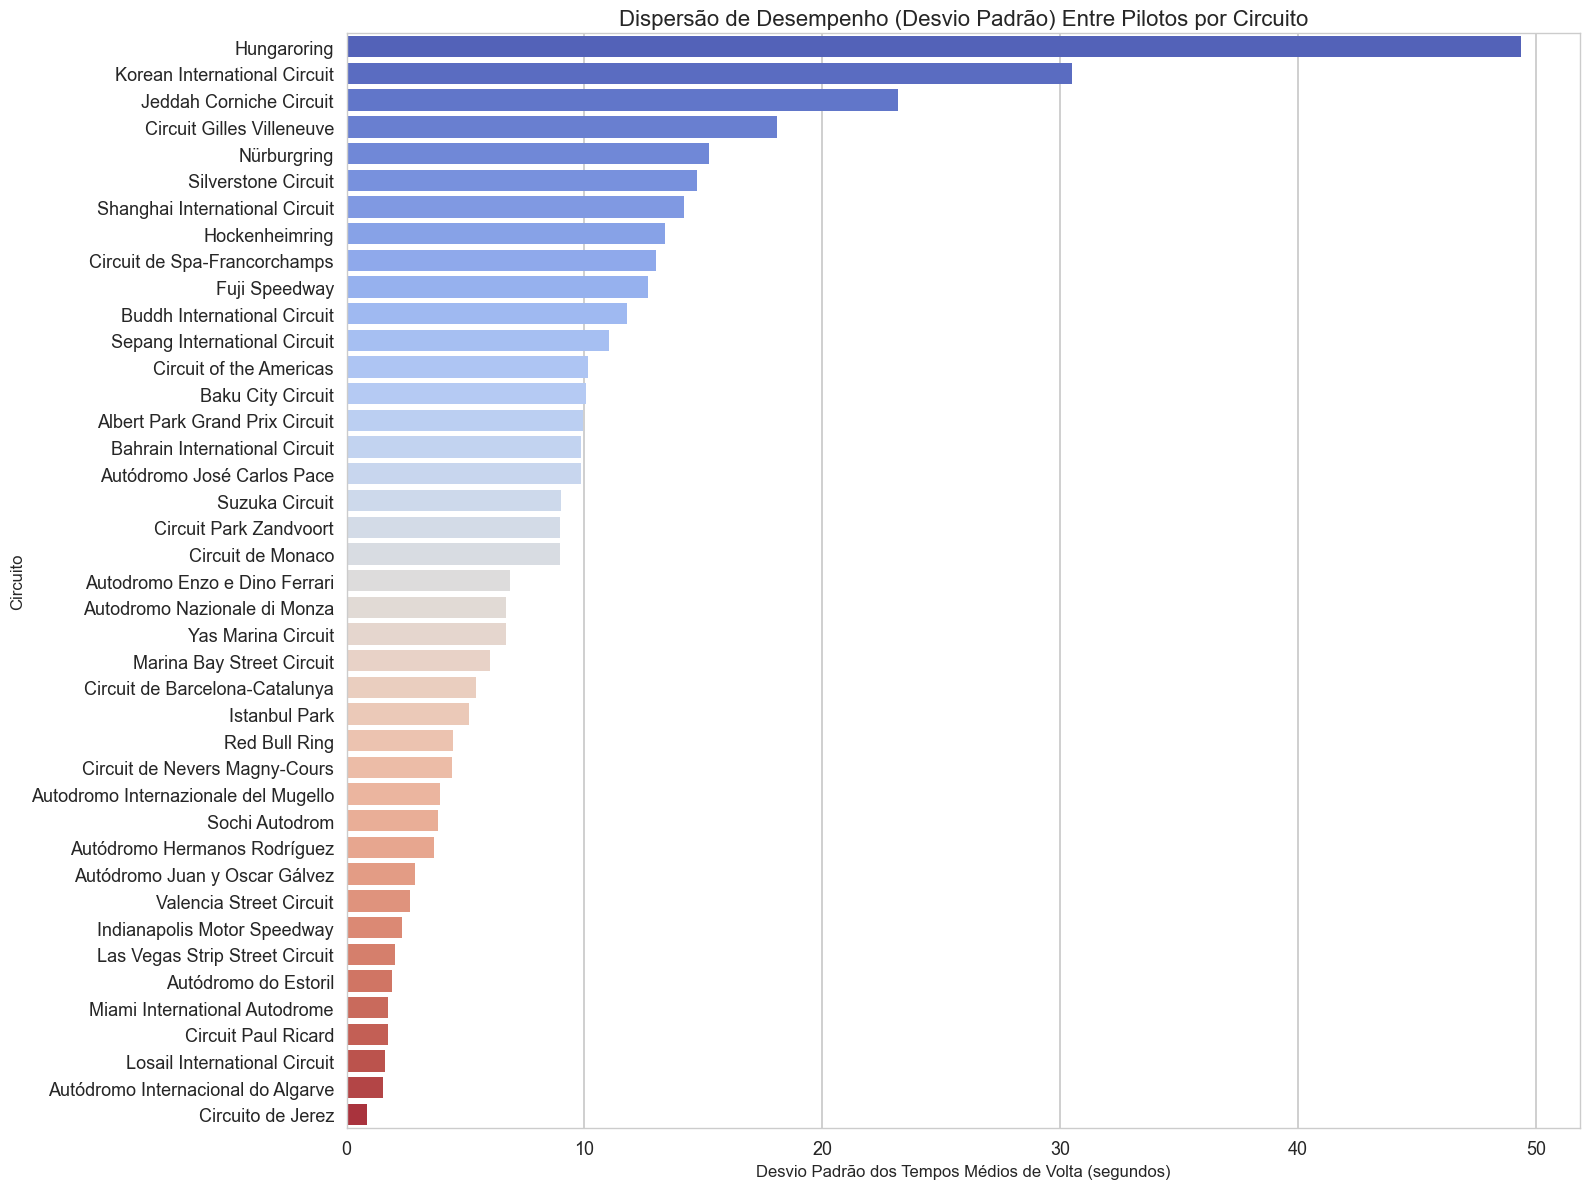

O circuito com a maior dispersão de tempos (sugestão de domínio) é: 'Hungaroring' com um desvio padrão de 49.385 segundos.
O circuito com a menor dispersão de tempos (sugestão de disputa acirrada) é: 'Circuito de Jerez' com um desvio padrão de 0.871 segundos.


In [387]:
from pyspark.sql.functions import avg, stddev, col
laps_with_races = dataframes['lap_times'].join(dataframes['races'], 'raceId')
avg_time_per_driver_circuit = laps_with_races.groupBy('circuitId', 'driverId').agg(avg('milliseconds').alias('avg_driver_circuit_ms'))
performance_spread_per_circuit = avg_time_per_driver_circuit.groupBy('circuitId').agg(stddev('avg_driver_circuit_ms').alias('spread_ms'))
spread_details = performance_spread_per_circuit.join(dataframes['circuits'], 'circuitId').withColumn('spread_s', col('spread_ms') / 1000).orderBy(col('spread_s').desc())
plot_data_14 = spread_details.select('name', 'spread_s').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_14, x='spread_s', y='name', orient='h', palette='coolwarm', hue='name', legend=False)
plt.title('Dispersão de Desempenho (Desvio Padrão) Entre Pilotos por Circuito', fontsize=16)
plt.xlabel('Desvio Padrão dos Tempos Médios de Volta (segundos)', fontsize=12)
plt.ylabel('Circuito', fontsize=12)
plt.tight_layout()
plt.show()
most_disputed_circuit = plot_data_14.iloc[-1]
most_dominated_circuit = plot_data_14.iloc[0]
print(f"O circuito com a maior dispersão de tempos (sugestão de domínio) é: '{most_dominated_circuit['name']}' com um desvio padrão de {most_dominated_circuit['spread_s']:.3f} segundos.")
print(f"O circuito com a menor dispersão de tempos (sugestão de disputa acirrada) é: '{most_disputed_circuit['name']}' com um desvio padrão de {most_disputed_circuit['spread_s']:.3f} segundos.")


### Evolução histórica do tempo médio


- **Objetivo do gráfico:** Acompanhar a evolução do tempo médio de volta ao longo das temporadas.
- **Dados utilizados:** `lap_times` enriquecidos com o ano proveniente de `races`.
- **Ações principais:** Junta voltas ao ano da corrida, calcula a média por temporada, converte para segundos, ordena cronologicamente e plota uma série temporal com marcadores.
- **Saída:** Gráfico `Evolução do Tempo Médio de Volta por Temporada` com eixo X formatado em anos inteiros.
- **Insight esperado:** Visualizar tendências de ganho ou perda de performance ligadas a mudanças de regulamento, tecnologia e pneus.
- **Próximo passo sugerido:** Anotar anos de grandes mudanças técnicas para contextualizar saltos ou quedas abruptas.


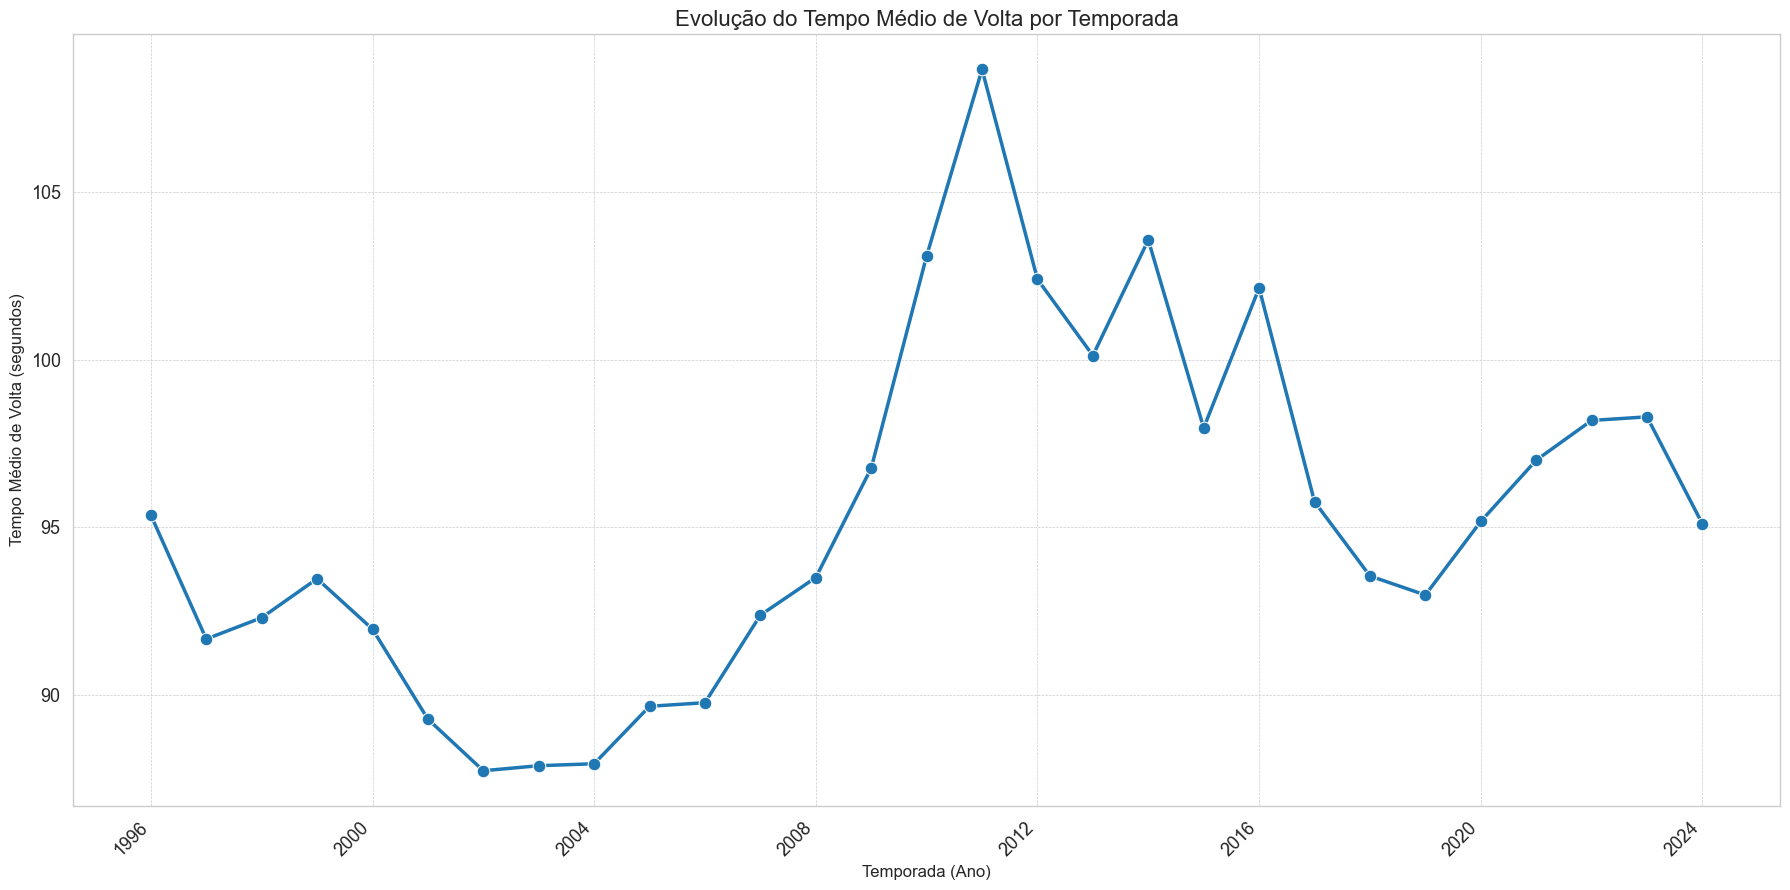

In [388]:
from pyspark.sql.functions import avg, col
from matplotlib.ticker import MaxNLocator
laps_with_year = dataframes['lap_times'].join(dataframes['races'], 'raceId')
avg_time_per_season = laps_with_year.groupBy('year').agg(avg('milliseconds').alias('avg_ms')).withColumn('avg_s', col('avg_ms') / 1000).orderBy('year')
plot_data_15 = avg_time_per_season.toPandas()
plt.figure(figsize=(18, 9))
ax = sns.lineplot(data=plot_data_15, x='year', y='avg_s', marker='o', linewidth=2.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45, ha='right')
plt.title('Evolução do Tempo Médio de Volta por Temporada', fontsize=16)
plt.xlabel('Temporada (Ano)', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Detecção de voltas outlier


- **Objetivo do gráfico:** Identificar voltas anormalmente lentas e quantificar quais pilotos mais sofreram com essas ocorrências.
- **Dados utilizados:** `lap_times` para médias e desvios por corrida, além de `drivers` e `races` para enriquecer os detalhes.
- **Ações principais:** Calcula média e desvio padrão por corrida, define limite de outlier (média + 2 desvios), filtra voltas acima do limiar, adiciona nomes e evento, agrupa por piloto e monta a tabela das 20 piores voltas.
- **Saída:** Gráfico `Contagem de Voltas "Outlier" (Muito Lentas) por Piloto` e tabela formatada `Top 20 Voltas Mais Lentas`.
- **Insight esperado:** Evidenciar pilotos e corridas onde ocorreram problemas significativos (falhas mecânicas, incidentes, penalidades).
- **Uso prático:** Apoiar relatórios de corrida destacando momentos críticos e avaliar confiabilidade de pilotos/equipes.


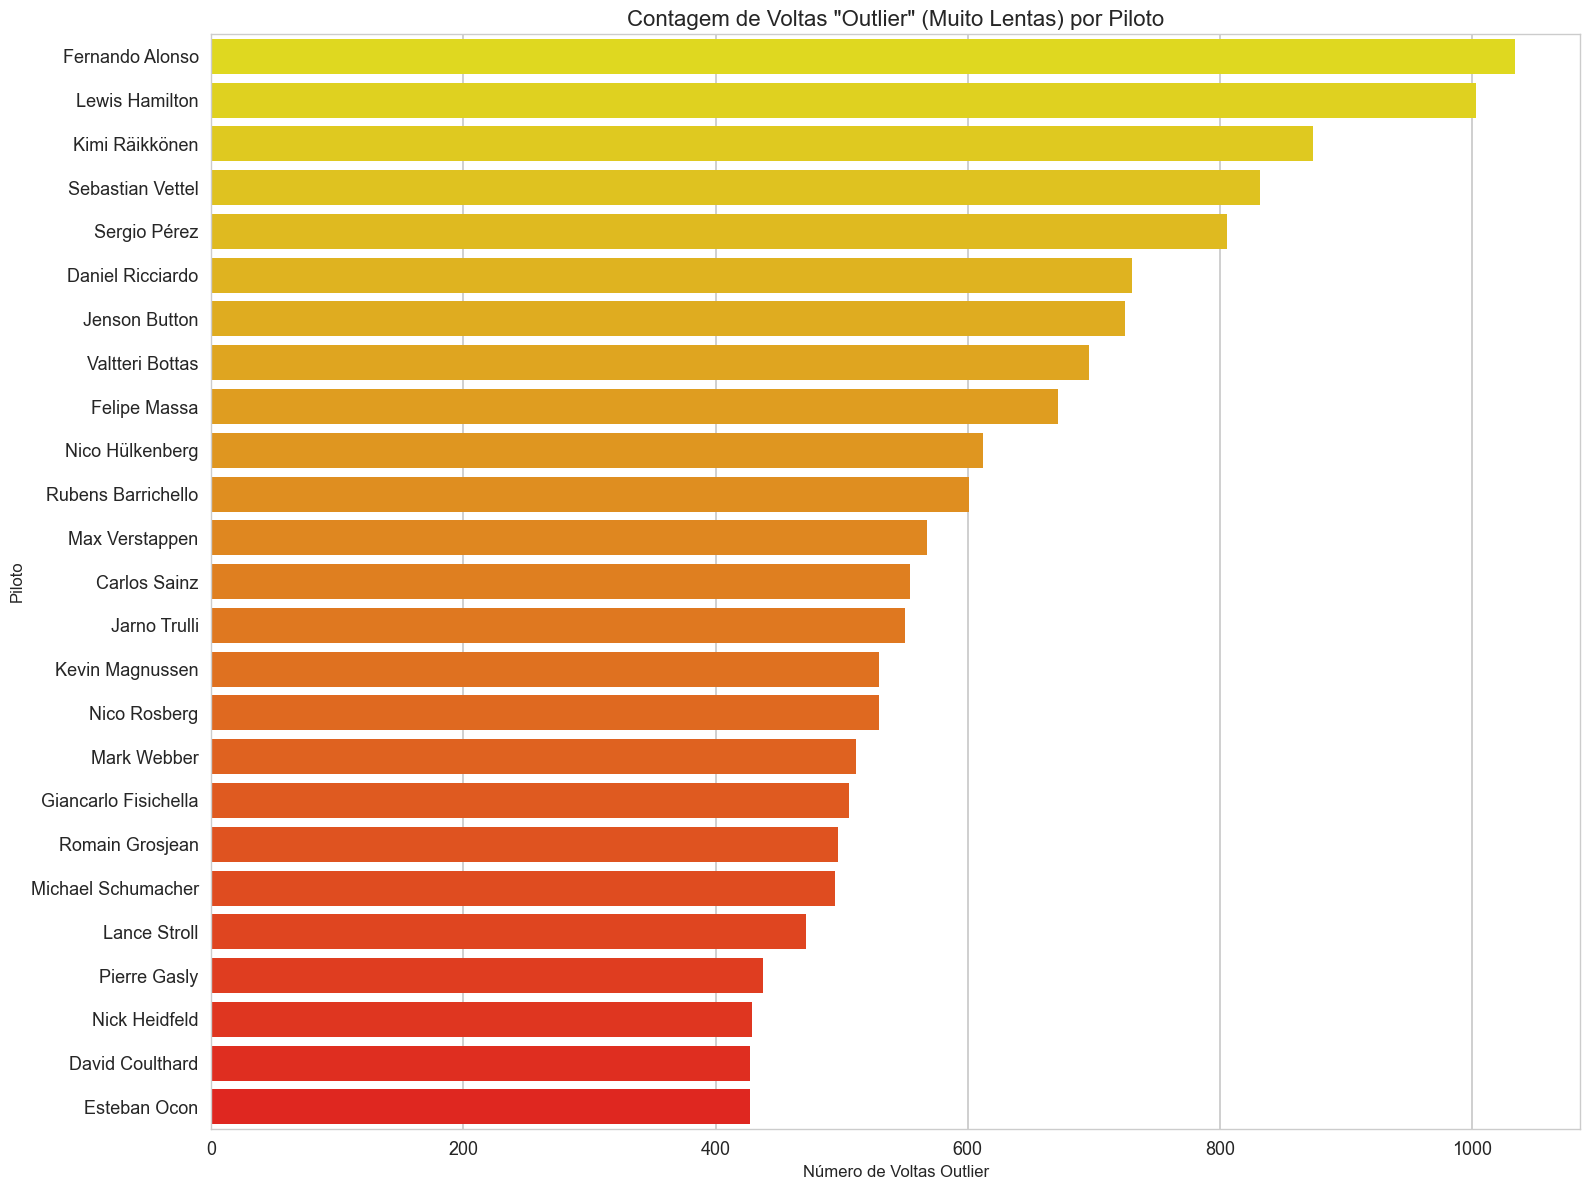


--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---


,race_event,driver_name,lap,lap_time_s,race_avg_s,slower_by_s
0,Canadian Grand Prix 2011,Nick Heidfeld,25,"7,507.55s",220.45s,"+7,287.10s"
1,Canadian Grand Prix 2011,Felipe Massa,25,"7,506.66s",220.45s,"+7,286.21s"
2,Canadian Grand Prix 2011,Vitaly Petrov,25,"7,506.24s",220.45s,"+7,285.79s"
3,Canadian Grand Prix 2011,Kamui Kobayashi,25,"7,506.10s",220.45s,"+7,285.64s"
4,Canadian Grand Prix 2011,Sebastian Vettel,25,"7,505.15s",220.45s,"+7,284.70s"
5,Canadian Grand Prix 2011,Mark Webber,25,"7,505.03s",220.45s,"+7,284.58s"
6,Canadian Grand Prix 2011,Fernando Alonso,25,"7,504.23s",220.45s,"+7,283.78s"
7,Canadian Grand Prix 2011,Paul di Resta,25,"7,503.98s",220.45s,"+7,283.53s"
8,Canadian Grand Prix 2011,Pedro de la Rosa,25,"7,503.80s",220.45s,"+7,283.34s"
9,Canadian Grand Prix 2011,Jenson Button,25,"7,503.77s",220.45s,"+7,283.32s"


In [389]:
from pyspark.sql.functions import avg, stddev, col, count, concat_ws
race_stats = dataframes['lap_times'].groupBy('raceId').agg(avg('milliseconds').alias('avg_ms_race'), stddev('milliseconds').alias('stddev_ms_race'))
laps_with_stats = dataframes['lap_times'].join(race_stats, 'raceId')
outlier_threshold = col('avg_ms_race') + 2 * col('stddev_ms_race')
outlier_laps = laps_with_stats.filter(col('milliseconds') > outlier_threshold)
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
races_with_label = dataframes['races'].withColumn('race_event', concat_ws(' ', col('name'), col('year')))
outliers_with_details = outlier_laps.join(drivers_with_label, 'driverId').join(races_with_label, 'raceId').withColumn('lap_time_s', col('milliseconds') / 1000).withColumn('race_avg_s', col('avg_ms_race') / 1000).withColumn('slower_by_s', (col('milliseconds') - col('avg_ms_race')) / 1000).orderBy(col('slower_by_s').desc())
outlier_counts_per_driver = outliers_with_details.groupBy('driver_name').agg(count('*').alias('outlier_count')).orderBy(col('outlier_count').desc())
plot_data_16 = outlier_counts_per_driver.toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_16.head(25), x='outlier_count', y='driver_name', orient='h', palette='autumn_r', hue='driver_name', legend=False)
plt.title('Contagem de Voltas "Outlier" (Muito Lentas) por Piloto', fontsize=16)
plt.xlabel('Número de Voltas Outlier', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
top_20_outliers_pd = outliers_with_details.select('race_event', 'driver_name', 'lap', 'lap_time_s', 'race_avg_s', 'slower_by_s').limit(20).toPandas()
print('\n--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---')
top_20_outliers_pd['lap_time_s'] = top_20_outliers_pd['lap_time_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['race_avg_s'] = top_20_outliers_pd['race_avg_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['slower_by_s'] = top_20_outliers_pd['slower_by_s'].map('+{:,.2f}s'.format)
display(top_20_outliers_pd)
